<h1 style="border-width:2px; border-style:solid; border-color:blue; background-color:#367395; text-align: center; text-shadow: 0px 0px 3px red; padding-bottom: 2em; padding-top: 1em;"><i>MACHINE LEARNING</i> PROJECT<br>HIGH VALUE CUSTOMERS IDENTIFICATION</h1>

About the project:

- Dataset originally from: https://www.kaggle.com/vik2012kvs/high-value-customers-identification

- In this fictional context, the challenge is to create a sistem to analyse the behaviour of customers in an e-commerce and divide them in groups with similar characteristics, in order to feed a marketing strategy.

- More info: see README.MD

Version 1: 2025.02.21

# 0. INITIAL PROCEDURES

In [1]:
run_step4_eda = True
run_step5_featureselection = False
run_step6_mloptimization = False

## 0.1 Imports

In [ ]:
import inflection
import itertools
import numpy       as np
import pandas      as pd
import random
import scipy.stats as st
import seaborn     as sns
import umap.umap_  as umap

from catboost            import CatBoostRegressor
from datetime            import datetime
from io                  import StringIO
from IPython.display     import Image
from lightgbm            import LGBMRegressor
from matplotlib          import pyplot   as plt
from plotly              import express  as px
from scipy               import stats
from scipy.cluster       import hierarchy     as hc
from sklearn             import cluster       as c
from sklearn             import decomposition as dd
from sklearn             import ensemble      as en
from sklearn             import manifold      as mn
from sklearn             import metrics       as m
from sklearn             import mixture       as mx
from sklearn             import preprocessing as pp
from sklearn.manifold    import TSNE
from sqlalchemy          import create_engine
from statsmodels         import api as sm
from xgboost             import XGBRegressor
from ydata_profiling     import ProfileReport


c:\Users\Manoel\miniconda3\envs\dscluster10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.2 Helper Functions

In [3]:
# To guarantee graphics directly in the notebook
%matplotlib inline

def vs_code_settings():
    # matplotlib configuration
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 10

    # show all columns & rows
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    # do not break dataframe prints in many lines
    pd.set_option( 'display.expand_frame_repr', False )

vs_code_settings()

## 0.3 Load Dataset

In [4]:
# Read CSV and decode as 'latin1'. Substitute weird chars.
path_local = "../data/raw/"

file_path = path_local + 'Ecommerce.csv'
with open(file_path, 'rb') as f:
    # decode and replace invalid chars
    content = f.read().decode('latin1', errors='replace')

# move to dataframe
df_raw = pd.read_csv(StringIO(content))
df_raw.shape

(541909, 9)

In [5]:
# drop last column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1. DATA DESCRIPTION

## 1.0. copy data, rename columns

In [6]:
# copy dataframe
df1 = df_raw.copy()
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
# rename columns
cols_old = df1.columns.to_list()

snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )

# renaming
df1.columns = cols_new
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

In [8]:
df_raw_customers = df1[['customer_id']].drop_duplicates( ignore_index=True ).reset_index(drop=True).copy()
df_raw_customers.shape

(4373, 1)

## 1.1. Verifying Types, NAs etc

In [9]:
print( 'N# of rows: {}'.format( df1.shape[0] ) )
print( 'N# of cols: {}'.format( df1.shape[1] ) )

N# of rows: 541909
N# of cols: 8


In [10]:
def verify_types_etc(df1):

    aux = pd.DataFrame( {'cols': df1.columns,
                        'DType': df1.dtypes,
                        'size': df1.shape[0],
                        'nunique': df1.nunique(),
                        'NAs': df1.isna().sum()} )
    aux['NA_percent%'] = round( 100 * aux['NAs'] / aux['size'], 1 )
    return aux

aux = verify_types_etc(df1)
aux

,cols,DType,size,nunique,NAs,NA_percent%
invoice_no,invoice_no,object,541909,25900,0,0.0
stock_code,stock_code,object,541909,4070,0,0.0
description,description,object,541909,4223,1454,0.3
quantity,quantity,int64,541909,722,0,0.0
invoice_date,invoice_date,object,541909,305,0,0.0
unit_price,unit_price,float64,541909,1630,0,0.0
customer_id,customer_id,float64,541909,4372,135080,24.9
country,country,object,541909,38,0,0.0


OOPS: almost 25% of registers show no 'customer_id' information.

- 1st moment: keep registers and run the clustering model.

- 2nd moment: delete those 25% and re-run the model.

## 1.2. Replace NAs

In [11]:
# [1] Synthesize a customer_id for the NA's
# ..OR..
# [2] Delete the unknowns (see section 2.2)

synthesize_customer_ids = False

if synthesize_customer_ids == True:
    #..... Synthesize customer_ids
    df_missing     = df1.loc[ df1['customer_id'].isna(), : ]
    df_not_missing = df1.loc[~df1['customer_id'].isna(), : ]
    # create reference
    df_bkp = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
    df_bkp['customer_id'] = np.arange( 19000, 19000+len(df_bkp), 1 )    # newly created customer_id

    # merge new IDs
    df1 = pd.merge( df1, df_bkp, on='invoice_no', how='left' )

    # coalesce
    df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

    # drop extra columns
    df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'] )

df1.shape

(541909, 8)

In [12]:
verify_types_etc(df1)

,cols,DType,size,nunique,NAs,NA_percent%
invoice_no,invoice_no,object,541909,25900,0,0.0
stock_code,stock_code,object,541909,4070,0,0.0
description,description,object,541909,4223,1454,0.3
quantity,quantity,int64,541909,722,0,0.0
invoice_date,invoice_date,object,541909,305,0,0.0
unit_price,unit_price,float64,541909,1630,0,0.0
customer_id,customer_id,float64,541909,4372,135080,24.9
country,country,object,541909,38,0,0.0


In [13]:
# Remove NAs in "description"
df1 = df1.dropna( subset=['description'] )
print( 'Total lines removed: {:.0f} ({:.2f}%)'.format( df_raw.shape[0]-df1.shape[0], 100-100*(df1.shape[0]/df_raw.shape[0]) ) )
print( 'N# of rows. . . . .: {}'.format( df1.shape[0] ) )
df1.shape

Total lines removed: 1454 (0.27%)
N# of rows. . . . .: 540455


(540455, 8)

## 1.3. Change dtypes

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

## 1.4. Country Lat&Long info

In [16]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [17]:
df1['country'].value_counts( normalize=True ).head()

country
United Kingdom    0.914089
Germany           0.017569
France            0.015833
EIRE              0.015165
Spain             0.004687
Name: proportion, dtype: float64

In [18]:
df1.shape

(540455, 8)

In [19]:
df1['country'].value_counts().sort_values(ascending=False).head(10)

country
United Kingdom    494024
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: count, dtype: int64

In [20]:
( df1[['customer_id','country']].drop_duplicates().groupby('country').count()
                                .reset_index().sort_values('customer_id', ascending=False).head(10) )

,country,customer_id
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


In [21]:
# There are 8 customers who have bought, supposedly, from two countries.
( df1[['customer_id','country']].drop_duplicates().groupby('customer_id').count()
                                .reset_index().sort_values('country', ascending=False).head(9) )

,customer_id,country
56,12417.0,2
20,12370.0,2
38,12394.0,2
90,12455.0,2
69,12431.0,2
67,12429.0,2
60,12422.0,2
92,12457.0,2
2919,16295.0,1


In [22]:
df_ref = df1[['customer_id']].drop_duplicates( ignore_index=True ).reset_index(drop=True).copy()
df_ref.shape

(4373, 1)

In [23]:
df_ref = df1[['customer_id', 'country']].drop_duplicates( ignore_index=True ).reset_index(drop=True).copy()
df_ref.shape

(4389, 2)

In [24]:
# For these 8 customers, we'll consider only one country: the one which sold the most.
# the_customers = [ 12417, 12422, 12455, 12429, 12457, 12431, 12394, 12370, 19106 ]

# Table of customers, countries & revenue
df_aux = df1.loc[ :, ['customer_id', 'country', 'quantity', 'unit_price'] ]
df_aux['revenue'] = df_aux['quantity'] * df_aux['unit_price']
df_aux = ( df_aux[['customer_id', 'country', 'revenue']].drop_duplicates()
                 .groupby(['customer_id', 'country']).sum().reset_index()
                 .sort_values(['customer_id','country'], ascending=False). reset_index(drop=True) )
# Get the country which sold the most for each customer
max_country = ( df_aux.loc[df_aux.groupby('customer_id')['revenue'].idxmax(), 
                          ['customer_id', 'country']]
                          .rename(columns={'country': 'max_country'}) 
              )
# change info in df1
df1 = df1.merge( max_country, on='customer_id', how='left' )
df1 = df1.drop( columns=['country'] )
df1 = df1.rename( columns={ 'max_country': 'country' } )
df1.sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
423009,573264,21931,JUMBO STORAGE BAG SUKI,10,2017-10-26,2.08,14415.0,United Kingdom
346236,567304,23406,HOME SWEET HOME KEY HOLDER,1,2017-09-17,6.25,14704.0,United Kingdom
293348,562715,23301,GARDENERS KNEELING PAD KEEP CALM,1,2017-08-06,3.29,NaN,NaN
483081,577531,85173,SET/6 FROG PRINCE T-LIGHT CANDLES,1,2017-11-18,4.96,NaN,NaN
460142,575943,21034,REX CASH+CARRY JUMBO SHOPPER,2,2017-11-11,0.95,17920.0,United Kingdom


In [25]:
# DONE !!!
( df1[['customer_id','country']].drop_duplicates().groupby('customer_id').count()
                                .reset_index().sort_values('country', ascending=False).head(4) )

,customer_id,country
0,12346.0,1
2913,16282.0,1
2919,16295.0,1
2918,16293.0,1


In [26]:
# INCLUDE LATITUDE & LONGITUDE INFO

# read list of countries & lat-long
# REF: https://developers.google.com/public-data/docs/canonical/countries_csv?hl=pt-br
df_countries = pd.read_excel( "../data/Paises.xlsx" )
df_countries.columns = [ 'country', 'latitude', 'longitude' ]

# merge
df1 = pd.merge( df1, df_countries, on='country', how='left' )
df1.shape

(540455, 10)

In [27]:
# Occurrence of NAN
df1.loc[ df1['latitude'].isna(), ['country', 'latitude'] ].drop_duplicates().head()

,country,latitude
1442,NaN,NaN
152088,Unspecified,NaN


In [28]:
# Remove NAs in "latitude" / "longitude"
df1 = df1.dropna( subset=['latitude'] )
print( 'Removed data: {:.0f} ({:.2f}%)'.format( df_raw.shape[0]-df1.shape[0], 100-100*(df1.shape[0]/df_raw.shape[0]) ) )
print( 'N# of rows: {}'.format( df1.shape[0] ) )
df1.shape

Removed data: 135324 (24.97%)
N# of rows: 406585


(406585, 10)

## 1.5. Descriptive Statistics

### Some notes:

Issues observed in the database:

**(1)** UnitPrice = ZERO in 2.515 registers. Most of them do not indicate a customer or description. "Quantity" feature ranges from negative to positive values. SOLUTION: delete 2515 registers.

**(2)** From 3.828 distinct stock_codes, there are 214 with two or more descriptions. Some cases differ by a comma in place of a space, or two spaces in place of one. In other cases, there are minor differences. Possible solutions: (1) use only STOCK_CODE feature, not DESCRIPTION feature, & (2) In order to use description, fix the problem by correcting the differences.

**(3)** From 4.033 distinct descriptions, there are 26 with two or more stock_codes. For example, stock codes 82580 & 21171. SOLUTION: keep the most frequent stock_code.

**(4)** The feature "country" include 'European Community' & 'Unspecified' with 5 and 13 invoices, respectively. They cannot be associated to LAT-LONG info. SOLUTION: delete.

**(5)** Features STOCKCODE & DESCRIPTION seem to represent not only products in stock, but also to internal control questions. The following control "codes" & "descriptions" may be found:

- "AMAZONFEE" & "AMAZON FEE": when present, these registers are the only one in the invoice. Values are not low, BUT there is NO CUSTOMER information. SOLUTION: delete.

- "B" & "Adjust bad debt": same as above. SOLUTION: delete.

- "BANK CHARGES" & "Bank Charges": same as above. SOLUTION: delete.

- "CRUK" & "CRUK Commission": CRUK = Cancer Research UK. All 16 occurences refer to customer=14096. Maybe he received an offer to contribute to charity, and accepted. SOLUTION: consider it a product or service and leave as is. Change quantity to abs(quantity)

- "D" & "Discount": that happens many times, refered to many customers. The "invoice_no" seems to have a rule of formation. If the main invoice is 123456, then the discount invoice will be C123457, both on the same day. SOLUTION: keep it. Keep quantity negative, since it's not a charge to the customer.

- "DCGSSBOY" & "BOYS PARTY BAG": despite of having a non-numerical StockCode, they seem like products to be sold. The descriptions indicate products aimed at children's parties, more specifically, themed goody bags for boys and girls. SOLUTION: keep it. No change in quantity.

- "DCGSSGIRL" & "GIRLS PARTY BAG": same as above. SOLUTION: keep it. No change in quantity.

- "DOT" & "DOTCOM POSTAGE": it is a cost in charge of the customer, and treated like a product in the invoice. Examples: invoices n# 539748 & 552230. PS: the value should be added to the invoice, but not the quantity of products, since it is a cost of service. SOLUTION: keep it. No change in quantity.

- "M" & "Manual": Not intuitive, difficult to be understood. SOLUTION: delete.

- "PADS" & "PADS TO MATCH ALL CUSHIONS": despite of having a non-numerical StockCode, it seems like a kind of product to be sold. SOLUTION: keep it. No change in quantity.

- "POST" & "POSTAGE": it is a cost in charge of the customer, and treated like a product in the invoice. Most of the customers are outside UK. SOLUTION: keep it. No change in quantity, which is sometimes positive, sometimes negative.

- "S" & "SAMPLES": most of the cases show negative quantity and no customer information. SOLUTION: delete.

### 1.5.0. copy data, separete numbers from non-numbers

In [29]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country', 'latitude', 'longitude'],
      dtype='object')

In [30]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
df1.shape

(406585, 10)

### 1.5.1. Numerical Attributes

In [31]:
def NumericalAttributesStats(num_attributes):

    # DESCRIPTIVE STATISTICS - NUMERICAL ATTRIBUTES
    # Dispersion (variance, standard deviation, max, min, range, skew, kurtosis)
    # central tendency (mean, median)

    # Central Tendency - mean, median
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
    d2 = pd.DataFrame( num_attributes.apply( min ) ).T
    d3 = pd.DataFrame( num_attributes.apply( max ) ).T
    d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
    d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

    # Concatenate the metrics
    m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).round(2).T.reset_index()
    m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

    return m1

m1 = NumericalAttributesStats( num_attributes )
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,12.06,5.00,248.77,0.18,94261.18
1,unit_price,0.00,38970.00,38970.00,3.46,1.95,69.34,452.08,246777.13
2,customer_id,12346.00,18287.00,5941.00,15288.63,15152.00,1713.28,0.03,-1.18
3,latitude,-30.56,64.96,95.52,54.40,55.38,5.54,-11.13,149.42
4,longitude,-106.35,138.25,244.60,-2.14,-3.44,10.40,9.21,134.45


#### Unit Price

In [32]:
df_aux = df1[ df1['unit_price']<0 ]
df_aux

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,latitude,longitude


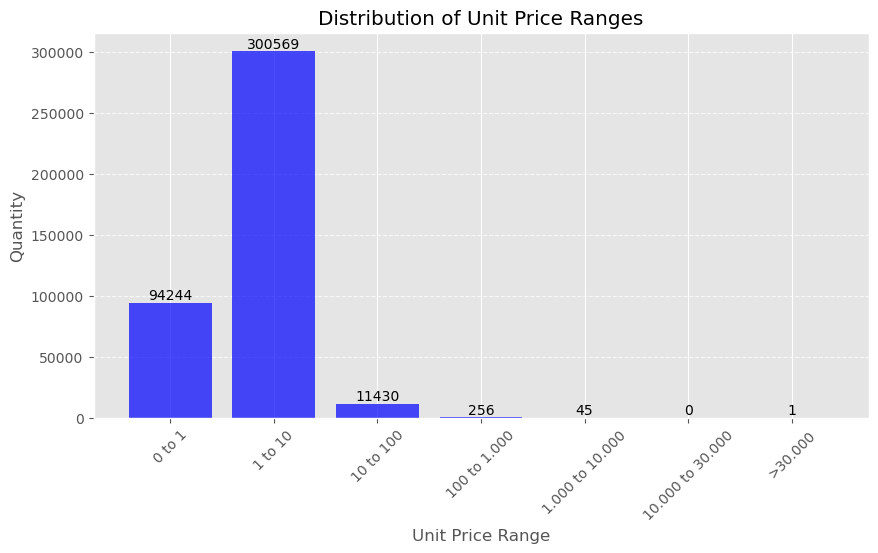

,unit_price range,Qty,%
1,0 to 1,94244,23.18
0,1 to 10,300569,73.93
2,10 to 100,11430,2.81
3,100 to 1.000,256,0.06
4,1.000 to 10.000,45,0.01
6,10.000 to 30.000,0,0.00
5,>30.000,1,0.00


In [33]:
# Define range values for "unit_price"
bins = [0, 1, 10, 100, 1000, 10000, 30000, float('inf')]
labels = ['0 to 1', '1 to 10', '10 to 100', '100 to 1.000', '1.000 to 10.000', '10.000 to 30.000', '>30.000']

# Cut 'unit_price' values to its ranges
df1['range_unit_price'] = pd.cut(df1['unit_price'], bins=bins, labels=labels)

# Count ranges' occurences
df_faixas = df1['range_unit_price'].value_counts().reset_index()
df1 = df1.drop( 'range_unit_price', axis=1 )

df_faixas.columns = ['unit_price range', 'Qty']
df_faixas = df_faixas.sort_values('unit_price range', ascending=True)
df_faixas['%'] = np.round( 100 * df_faixas['Qty'] / df1.shape[0] , 2)

# Plot histogram
plt.figure(figsize=(10, 5))
bars = plt.bar(df_faixas['unit_price range'], df_faixas['Qty'], color='blue', alpha=0.7)
plt.xlabel('Unit Price Range')
plt.ylabel('Quantity')
plt.title('Distribution of Unit Price Ranges')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels to bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10)

plt.show()

df_faixas

### 1.5.2. Categorical Attributes

In [34]:
df1.shape

(406585, 10)

#### Invoice No

In [35]:
# Verifying invoices with alphanumeric codes (optimized)
df_aux = df1[df1['invoice_no'].str.contains(r'[^0-9]', regex=True, na=False)]
print(f'Total number of invoices . . . . . : {len(df_aux)}')

Total number of invoices . . . . . : 8905


#### Stock Code

In [36]:
# 'only char' stock_codes (optimized)
df1.loc[df1['stock_code'].str.fullmatch(r'[a-zA-Z]+', na=False), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

# 2. DATA FILTERING

## 2.0. Copy data

In [37]:
df2 = df1.copy()
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,latitude,longitude
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom,55.378051,-3.435973
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom,55.378051,-3.435973
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom,55.378051,-3.435973
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom,55.378051,-3.435973
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom,55.378051,-3.435973


## 2.1. "Uppercasing"

In [38]:
# Force uppercase, specially "invoice_no" & "stock_code", which may contain ALPHAs
# (Avoid problems like: stock_code = '82001S' and '82001s')

cols = ['invoice_no', 'stock_code', 'description']
df2[cols] = df2[cols].apply(lambda col: col.astype(str).str.upper())

# Force "titling" country names
df2['country'] = df2['country'].astype(str).str.title()
df2.sample(6)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,latitude,longitude
326279,565670,23144,ZINC T-LIGHT HOLDER STARS SMALL,12,2017-09-04,0.83,14944.0,United Kingdom,55.378051,-3.435973
110101,545687,20726,LUNCH BAG WOODLAND,4,2017-03-04,1.65,17769.0,United Kingdom,55.378051,-3.435973
254456,559342,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2017-07-05,1.69,14493.0,United Kingdom,55.378051,-3.435973
519087,580289,22940,FELTCRAFT CHRISTMAS FAIRY,1,2017-11-30,4.25,15856.0,United Kingdom,55.378051,-3.435973
370193,569220,21429,RED GINGHAM ROSE JEWELLERY BOX,2,2017-09-30,1.95,16007.0,United Kingdom,55.378051,-3.435973
101433,544930,21212,PACK OF 72 RETROSPOT CAKE CASES,2,2017-02-22,0.55,17472.0,United Kingdom,55.378051,-3.435973


## 2.2. Delete Rows

In [39]:
# ==== Numerical Attributes ====
# unit price > 0.0 [prices==ZERO or bellow are deleted]
df2 = df2.loc[df2['unit_price'] > 0, :]

# ==== Categorical Attributes ====
# country: delete "Unspecified", since we cannot define LAT & LONGITUDE
df2 = df2[ ~df2['country'].isin( ['Unspecified'] ) ]

# stock codes to be deleted
df2 = df2[~df2['stock_code'].isin( ['AMAZONFEE', 'B', 'BANK CHARGES', 'M', 'S'] )]
df2.shape

(406074, 10)

In [40]:
df2.loc[df2['stock_code'] == 'CRUK', :].head(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,latitude,longitude
316378,C564763,CRUK,CRUK COMMISSION,-1,2017-08-28,1.60,14096.0,United Kingdom,55.378051,-3.435973
322854,C565382,CRUK,CRUK COMMISSION,-1,2017-08-31,13.01,14096.0,United Kingdom,55.378051,-3.435973
332597,C566216,CRUK,CRUK COMMISSION,-1,2017-09-07,15.96,14096.0,United Kingdom,55.378051,-3.435973


In [41]:
# stock_code=CRUK should have it's quantity forced to be positive
# WHY?: 'cause it refers to costs supported by customer, so we'll treat it like a "product"
df2.loc[df2['stock_code'] == 'CRUK', 'quantity'] = df2['quantity'].abs()
df2.loc[df2['stock_code'] == 'CRUK', :].head(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,latitude,longitude
316378,C564763,CRUK,CRUK COMMISSION,1,2017-08-28,1.60,14096.0,United Kingdom,55.378051,-3.435973
322854,C565382,CRUK,CRUK COMMISSION,1,2017-08-31,13.01,14096.0,United Kingdom,55.378051,-3.435973
332597,C566216,CRUK,CRUK COMMISSION,1,2017-09-07,15.96,14096.0,United Kingdom,55.378051,-3.435973


In [42]:
# As a first result of "4.1 UNIVARIATE ANALYSIS", let's delete some rows

# [1] Delete rows for customer_id = 12346, 16446, 15098, 15749
df2 = df2[ ~df2['customer_id'].isin( [ 12346, 16446, 15098, 15749 ] ) ]

# [2] Delete rows to which RETURN_RATE > 0.9
customer_list = [17548, 16546, 17547, 13958, 16995, 14213, 14679, 19071, 16138, 12870, 
                 16252, 16579, 17307, 12605, 19210, 18141, 16262, 12666, 13829, 17820, 
                 14777, 18256, 14119, 19299, 19305, 19338, 19346, 15823, 19363, 13672, 
                 19394, 12346, 19420, 13693, 19513, 14627, 19561, 19590, 19617, 15638, 
                 12943, 19759, 16061, 19879, 19903, 19909, 19995, 20002, 20005, 20006, 
                 20007, 20008, 20114, 13762, 20634, 20635, 20636, 20637, 20638, 16446, 
                 20688, 20691, 20762, 17900, 20918, 21005, 21006, 21065, 21208, 21246, 
                 21331, 18268, 21430, 21432, 21468, 21535, 14557, 16878, 16428, 21769, 
                 13364, 21892, 14792, 12607, 21993, 22036, 12454, 15728, 22091, 16742, 
                 22092, 22093, 22094, 22095, 22096, 22097, 22098, 22099, 22100, 22101, 
                 22103, 22181, 22280, 22320, 18274, 22485, 22515, 22610, 22616, 12558]
df2 = df2[ ~df2['customer_id'].isin( customer_list ) ]

# [3] Delete rows for 94 customers with no purchase, only returns (already done above)

df2.shape

(405522, 10)

In [43]:
# Delete rows for customer_id = NaN
df2 = df2.dropna( subset=['customer_id'] )
df2['customer_id'] = df2['customer_id'].astype( np.int64 )
df2.shape

(405522, 10)

## 2.3. Description Column

In [44]:
df2[df2['description'].str.contains(',', regex=False, na=False)].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,latitude,longitude
109,536381,82567,"AIRLINE LOUNGE,METAL SIGN",2,2016-11-29,2.10,15311,United Kingdom,55.378051,-3.435973
253,536394,21506,"FANCY FONT BIRTHDAY CARD,",24,2016-11-29,0.42,13408,United Kingdom,55.378051,-3.435973
955,536520,22760,"TRAY, BREAKFAST IN BED",1,2016-11-29,12.75,14729,United Kingdom,55.378051,-3.435973
1013,536520,21111,"SWISS ROLL TOWEL, CHOCOLATE SPOTS",1,2016-11-29,2.95,14729,United Kingdom,55.378051,-3.435973
1082,536524,21111,"SWISS ROLL TOWEL, CHOCOLATE SPOTS",6,2016-11-29,2.95,17572,United Kingdom,55.378051,-3.435973


In [45]:
# DESCRIPTION Attribute - task.1:
# words should be separeted by one space, instead of N spaces, or comma, or whatever
# Substitute commas per spaces
df2['description'] = df2['description'].str.replace(',', ' ', regex=False).str.split().str.join(' ')
df2.iloc[109]

invoice_no                         536381
stock_code                          82567
description     AIRLINE LOUNGE METAL SIGN
quantity                                2
invoice_date          2016-11-29 00:00:00
unit_price                            2.1
customer_id                         15311
country                    United Kingdom
latitude                        55.378051
longitude                       -3.435973
Name: 109, dtype: object

In [46]:
# DESCRIPTION Attribute - task.2:

# There are 214 distinct stock_codes with two or more descriptions.
# Example: stock_code = 17107D
# Solution: adopt the most frequent description in each case.

df_aux = ( df2.groupby(['stock_code', 'description']).size()
              .reset_index(name='freq') )
#df_aux[ df_aux['stock_code'] == '17107D' ]

df_aux2 = ( df_aux.sort_values('freq', ascending=False)
                  .drop_duplicates(subset='stock_code')
                  .rename(columns={'description': 'unique_description'})
                  [['stock_code', 'unique_description']] )
#df_aux2[ df_aux2['stock_code'] == '17107D' ]

df2 = df2.merge(df_aux2, on='stock_code', how='left')
#df3[ df3['stock_code'] == '17107D' ]
df2['description'] = df2['unique_description']
df2 = df2.drop(columns=['unique_description'])
# verifying: OK if no regs come
df2[ df2['description'] == "FLOWER FAIRY 5 DRAWER LINERS" ]


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,latitude,longitude


In [47]:
# DESCRIPTION Attribute - task.3:

# There are 26 distinct descriptions with two or more stock_codes.
# Example: description = "BATHROOM METAL SIGN" --> stock_codes = 82580 & 21171
# Solution: adopt the most frequent stock_code in each case.

df_aux = (
    df2.groupby(['description', 'stock_code'])
    .size()
    .reset_index(name='freq')
)
df_aux[ df_aux['description'] == 'BATHROOM METAL SIGN' ]

df_aux2 = (
    df_aux.sort_values('freq', ascending=False)
    .drop_duplicates(subset='description')
    .rename(columns={'stock_code': 'codigo_unico'})
    [['description', 'codigo_unico']]
)
df_aux2[ df_aux2['description'] == 'BATHROOM METAL SIGN' ]

df2 = df2.merge(df_aux2, on='description', how='left')
#df3[ df3['description'] == 'BATHROOM METAL SIGN' ]
df2['stock_code'] = df2['codigo_unico']
df2 = df2.drop(columns=['codigo_unico'])
# verifying: OK if no regs come
df2[ df2['stock_code'] == '21171' ]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,latitude,longitude


In [48]:
#.......... Discard description column
# (previous tests showed no improvement to customers' clustering)
df2 = df2.drop( 'description', axis=1 )
df2.shape

(405522, 9)

## 2.4. Create dataframes: df_purchase & df_return

In [49]:
# ==== Back to Numerical Attributes ====
## quantity - Negative numbers means product return
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity']  >= 0, :]

In [50]:
# Verify once again...
verify_types_etc(df2)

,cols,DType,size,nunique,NAs,NA_percent%
invoice_no,invoice_no,object,405522,21900,0,0.0
stock_code,stock_code,object,405522,3646,0,0.0
quantity,quantity,int64,405522,417,0,0.0
invoice_date,invoice_date,datetime64[ns],405522,305,0,0.0
unit_price,unit_price,float64,405522,515,0,0.0
customer_id,customer_id,int64,405522,4312,0,0.0
country,country,object,405522,36,0,0.0
latitude,latitude,float64,405522,36,0,0.0
longitude,longitude,float64,405522,36,0,0.0


In [51]:
# Verify once again...
NumericalAttributesStats( df2.select_dtypes( include=['int64', 'float64'] ) )

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-9360.00,4800.00,14160.00,12.04,5.00,44.44,0.01,6222.04
1,unit_price,0.00,8142.75,8142.75,3.08,1.95,20.19,331.93,130795.57
2,customer_id,12347.00,18287.00,5940.00,15290.15,15152.00,1712.30,0.03,-1.18
3,latitude,-30.56,64.96,95.52,54.42,55.38,5.51,-11.24,151.97
4,longitude,-106.35,138.25,244.60,-2.09,-3.44,10.14,10.29,144.15


# 3. FEATURE ENGINEERING

## 3.0. Copy data

In [52]:
df3 = df2.copy()
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country,latitude,longitude
0,536365,85123A,6,2016-11-29,2.55,17850,United Kingdom,55.378051,-3.435973
1,536365,71053,6,2016-11-29,3.39,17850,United Kingdom,55.378051,-3.435973
2,536365,84406B,8,2016-11-29,2.75,17850,United Kingdom,55.378051,-3.435973
3,536365,84029G,6,2016-11-29,3.39,17850,United Kingdom,55.378051,-3.435973
4,536365,84029E,6,2016-11-29,3.39,17850,United Kingdom,55.378051,-3.435973


In [53]:
df3.shape

(405522, 9)

## 3.1. RFM Features Creation

RFM = Recency, Frequency, Monetary

In [54]:
# Preraring a DataFrame of Customers

df_ref = df3[['customer_id', 'country', 'latitude', 'longitude']].drop_duplicates( ignore_index=True ).reset_index(drop=True).copy()
df_ref.shape

(4312, 4)

In [55]:
df_ref.head()

,customer_id,country,latitude,longitude
0,17850,United Kingdom,55.378051,-3.435973
1,13047,United Kingdom,55.378051,-3.435973
2,12583,France,46.227638,2.213749
3,13748,United Kingdom,55.378051,-3.435973
4,15100,United Kingdom,55.378051,-3.435973


### 3.1.1. Feature-1: Gross Revenue (total, per weekday, per monthday)

In [56]:
df2_purchase.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country,latitude,longitude
0,536365,85123A,6,2016-11-29,2.55,17850,United Kingdom,55.378051,-3.435973
1,536365,71053,6,2016-11-29,3.39,17850,United Kingdom,55.378051,-3.435973
2,536365,84406B,8,2016-11-29,2.75,17850,United Kingdom,55.378051,-3.435973
3,536365,84029G,6,2016-11-29,3.39,17850,United Kingdom,55.378051,-3.435973
4,536365,84029E,6,2016-11-29,3.39,17850,United Kingdom,55.378051,-3.435973


In [57]:
#.......... Define gross_revenue for each item
df2_purchase = df2_purchase.assign(gross_revenue=df2_purchase['quantity'] * df2_purchase['unit_price'])

#.......... Define weekly gross_revenue
# Create one temporary column (populated with: 'Monday', 'Tuesday', ... )
df2_purchase['day_of_week'] = df2_purchase['invoice_date'].dt.day_name()
# Create weekdays columns
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in days_of_week:
    df2_purchase[day] = 0.0

# Allocate gross_revenue values to respective cols
df2_purchase.loc[df2_purchase['day_of_week'] == 'Monday',    'Monday']    = df2_purchase['gross_revenue']
df2_purchase.loc[df2_purchase['day_of_week'] == 'Tuesday',   'Tuesday']   = df2_purchase['gross_revenue']
df2_purchase.loc[df2_purchase['day_of_week'] == 'Wednesday', 'Wednesday'] = df2_purchase['gross_revenue']
df2_purchase.loc[df2_purchase['day_of_week'] == 'Thursday',  'Thursday']  = df2_purchase['gross_revenue']
df2_purchase.loc[df2_purchase['day_of_week'] == 'Friday',    'Friday']    = df2_purchase['gross_revenue']
df2_purchase.loc[df2_purchase['day_of_week'] == 'Saturday',  'Saturday']  = df2_purchase['gross_revenue']
df2_purchase.loc[df2_purchase['day_of_week'] == 'Sunday',    'Sunday']    = df2_purchase['gross_revenue']

#.......... Define monthly gross_revenue
# Create temporary column
df2_purchase['day_of_month'] = df2_purchase['invoice_date'].dt.day

# Create 31 columns for days of month
df_pivot = df2_purchase.pivot_table(index=df2_purchase.index, 
                                    columns='day_of_month', 
                                    values='gross_revenue', 
                                    aggfunc='sum', 
                                    fill_value=0)

df_pivot.columns = [f"day_{int(col):02d}" for col in df_pivot.columns]
df2_purchase = pd.concat( [df2_purchase, df_pivot], axis=1 )

# del temporary columns
df2_purchase = df2_purchase.drop(['day_of_week', 'day_of_month'], axis=1)
df2_purchase.shape

(397124, 48)

In [58]:
df2_purchase.columns

Index(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price',
       'customer_id', 'country', 'latitude', 'longitude', 'gross_revenue',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', 'day_01', 'day_02', 'day_03', 'day_04', 'day_05', 'day_06',
       'day_07', 'day_08', 'day_09', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20',
       'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
       'day_28', 'day_29', 'day_30', 'day_31'],
      dtype='object')

In [59]:
# Verify if any column is zeroed
columns_with_only_zeros = []
for day in range(1, 32):
    column_name = f"day_{day:02d}"
    if (df2_purchase[column_name] == 0).all():
        columns_with_only_zeros.append(column_name)

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in days_of_week:
    if (df2_purchase[day] == 0).all():
        columns_with_only_zeros.append(day)

# If it is the case, DELETE.
if len(columns_with_only_zeros)>0:
    df2_purchase = df2_purchase.drop( columns_with_only_zeros, axis=1 )

print("Zeroed columns:", columns_with_only_zeros)

Zeroed columns: ['Friday']


In [60]:
# Feature-1: Gross Revenue = quantity * price [grouping by customer]
days_of_week  = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday']
days_of_month = [f"day_{i:02d}" for i in range(1, 32)]
feats = [ 'customer_id', 'gross_revenue' ] + days_of_week + days_of_month
df_aux = df2_purchase[feats].groupby( 'customer_id' ).sum().reset_index()
# Merge
df_ref = pd.merge( df_ref, df_aux, on='customer_id', how='left' )
df_ref['gross_revenue'] = df_ref['gross_revenue'].fillna(0)  # Here, NA means ZERO revenue
df_ref.shape

(4312, 42)

In [61]:
df_ref.sample(6)

,customer_id,country,latitude,longitude,gross_revenue,Monday,Tuesday,Wednesday,Thursday,Saturday,Sunday,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
173,15299,United Kingdom,55.378051,-3.435973,3907.01,0.0,0.00,1835.01,0.0,0.00,2072.0,1472.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1835.01,0.0
3522,17506,United Kingdom,55.378051,-3.435973,302.20,0.0,0.00,0.00,0.0,302.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,302.2,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
3695,16248,United Kingdom,55.378051,-3.435973,152.94,0.0,0.00,0.00,0.0,152.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
60,15350,United Kingdom,55.378051,-3.435973,115.65,0.0,115.65,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.65,0.00,0.0
2399,12506,France,46.227638,2.213749,73.50,0.0,0.00,73.50,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
201,17396,United Kingdom,55.378051,-3.435973,7312.80,0.0,0.00,4386.30,397.5,0.00,2529.0,2431.5,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,4386.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,495.00,0.00,0.0


### 3.1.2. Feature-2: Recency

In [62]:
# Feature-2: Recency [how many days passed since last purchase]

# max(date) per customer
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
# recency_days = how many days passed since last buy, per each customer
df_recency['recency_days'] = ( df3['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()

# Merge
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

# Solving NAs.
# first day & last day of the database
first_day = df3['invoice_date'].min()
last_day  = df3['invoice_date'].max()
max_days = ( last_day - first_day ).days
df_ref['recency_days'] = df_ref['recency_days'].fillna(max_days)  # Here, NA means 'the worst case'
df_ref.shape

(4312, 43)

### 3.1.3. Feature-3: Sum of invoices per customer

In [63]:
# Sum of invoices per customer
df_freq = ( df2_purchase[['customer_id', 'invoice_no']].drop_duplicates()
                                                       .groupby( 'customer_id' )
                                                       .count().reset_index()
                                                       .rename(columns={'invoice_no':'qtty_invoices'}) )
# Merge
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref['qtty_invoices'] = df_ref['qtty_invoices'].fillna(0)  # Here, NA means ZERO invoices
df_ref.shape

(4312, 44)

### 3.1.4. Feature-4: Total quantity of items per customer

In [64]:
# Sum of products per customer
df_freq = ( df2_purchase[['customer_id', 'quantity']].groupby( 'customer_id' )
                                                     .sum().reset_index()
                                                     .rename(columns={'quantity':'qtty_items'}) )
# Merge
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref['qtty_items'] = df_ref['qtty_items'].fillna(0)  # Here, NA means ZERO items
df_ref.shape

(4312, 45)

### 3.1.5. Feature-5: Sum of unique products per customer

In [65]:
df_freq = ( df2_purchase[['customer_id', 'stock_code']].drop_duplicates()
                                                       .groupby( 'customer_id' )
                                                       .count().reset_index()
                                                       .rename(columns={'stock_code':'qtty_unique_items'}) )
# Merge
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref['qtty_unique_items'] = df_ref['qtty_unique_items'].fillna(0)  # Here, NA means ZERO items
df_ref.shape

(4312, 46)

### 3.1.6. Feature-6: Average ticket value

In [66]:
# Feature-6: Avg Ticket [avg revenue per line of data, per customer]
df_aux = ( df2_purchase[['customer_id', 'gross_revenue']].groupby( 'customer_id' )
                                                         .mean().reset_index()
                                                         .rename( columns={'gross_revenue':'avg_ticket'} ) )
# Merge
df_ref = pd.merge( df_ref, df_aux, on='customer_id', how='left' )
df_ref['avg_ticket'] = df_ref['avg_ticket'].fillna(0)  # Here, NA means ZERO revenue
df_ref.shape

(4312, 47)

### 3.1.7. Feature-7: Average Recency Days

In [67]:
# Average Recency Days: number of days (in average) between two purchases
# avg_recency = (day_of_last_purchase - day_of_first_purchase) / (num_of_invoices - 1)
#          or = num_of_days / (num_of_invoices - 1)
# Problems to observe: if num_of_invoices = 0 or 1...
#     [1] if num_of_invoices = 0, then impose: avg_recency = max_days
#     [2] if num_of_invoices = 1, then impose: avg_recency = recency_days

# first day & last day of the database
first_day = df3['invoice_date'].min()
last_day  = df3['invoice_date'].max()
max_days = ( last_day - first_day ).days

# list of customers
df_aux = df3[['customer_id']].drop_duplicates().reset_index(drop=True).copy()

# day_of_first_purchase
df_aux2 = ( df2_purchase[['customer_id', 'invoice_date']]
                .groupby( 'customer_id' ).min()
                .reset_index()
                .rename( columns={'invoice_date':'first_purchase'} ) 
          )
df_aux = pd.merge( df_aux, df_aux2, on='customer_id', how='left' )
df_aux['first_purchase'] = df_aux['first_purchase'].fillna(first_day)

# day_of_last_purchase
df_aux2 = ( df2_purchase[['customer_id', 'invoice_date']]
                .groupby( 'customer_id' ).max()
                .reset_index()
                .rename( columns={'invoice_date':'last_purchase'} ) )
df_aux = pd.merge( df_aux, df_aux2, on='customer_id', how='left' )
df_aux['last_purchase'] = df_aux['last_purchase'].fillna(last_day)

# num_of_invoices
df_aux2 = ( df2_purchase[['customer_id', 'invoice_no']]
                  .drop_duplicates()
                  .groupby( 'customer_id' ).count()
                  .reset_index()
                  .rename(columns={'invoice_no':'qtde_invoices'})
          )
df_aux = pd.merge( df_aux, df_aux2, on='customer_id', how='left' )
df_aux['qtde_invoices'] = df_aux['qtde_invoices'].fillna(0) # force result

# N# of days the customer made a purchase, regardless the n# of invoices a day
df_aux2 = ( df2_purchase[['customer_id', 'invoice_date']]
                  .drop_duplicates()
                  .groupby( 'customer_id' ).count()
                  .reset_index()
                  .rename(columns={'invoice_date':'qtde_days_of_purchase'})
          )
df_aux = pd.merge( df_aux, df_aux2, on='customer_id', how='left' )
df_aux['qtde_days_of_purchase'] = df_aux['qtde_days_of_purchase'].fillna(0)

# In case of only one invoice, or only one day of purchase
df_aux['last_purchase'] = pd.to_datetime(
    np.where(df_aux['qtde_days_of_purchase'] == 1, last_day, df_aux['last_purchase'])
)
df_aux['qtde_days_of_purchase'] = np.where(
    df_aux['qtde_days_of_purchase'] == 1, 2, df_aux['qtde_days_of_purchase']
)

# Num_days
df_aux['num_days'] = (df_aux['last_purchase'] - df_aux['first_purchase']).dt.days
df_aux['num_days'] = df_aux['num_days'].replace(0, max_days)

# Average Recency Days
df_aux['avg_recency'] = np.where(
    df_aux['qtde_invoices'] == 0,
    max_days,
    df_aux['num_days'] / ( df_aux['qtde_days_of_purchase'] -1 )
)
df_aux2 = df_aux[['customer_id', 'avg_recency']]

# Merge
df_ref = pd.merge( df_ref, df_aux2, on='customer_id', how='left' )
df_ref.shape

(4312, 48)

In [68]:
df_aux[ df_aux['qtde_days_of_purchase'] == 2 ].head()   # debugging

,customer_id,first_purchase,last_purchase,qtde_invoices,qtde_days_of_purchase,num_days,avg_recency
0,17850,2016-11-29,2016-11-30,34,2,1,1.0
11,18074,2016-11-29,2017-12-07,1,2,373,373.0
14,16250,2016-11-29,2017-03-21,2,2,112,112.0
18,13747,2016-11-29,2017-12-07,1,2,373,373.0
25,12791,2016-11-29,2017-12-07,1,2,373,373.0


In [69]:
df_ref[np.isinf(df_ref['avg_recency'])].head()

,customer_id,country,latitude,longitude,gross_revenue,Monday,Tuesday,Wednesday,Thursday,Saturday,Sunday,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,recency_days,qtty_invoices,qtty_items,qtty_unique_items,avg_ticket,avg_recency


### 3.1.8. Feature-8: Frequency

In [70]:
# Frequency = Avg number of invoices per day (can be a fraction, 0<freq<1)
# PS: two or more invoices in a day count as one

feats = ['customer_id', 'invoice_date']

# In case of customers with only one purchase, we may have: buy_ = days_ = 1 [no good]
# Let the feature consider the final 'not_buying' time, with: max_ = last_day
last_day  = df3['invoice_date'].max()  # last day of the database

# Get rid of duplicates before grouping
df_aux = df2_purchase[feats].drop_duplicates()

# Agrupar por 'customer_id' e calcular agregações de forma eficiente
df_aux = df_aux.groupby('customer_id').agg(
    min_=('invoice_date', 'min'),  # Data da primeira compra
    buy_=('invoice_date', 'count') # Número total de compras
).reset_index()

# Adicionar max_ diretamente como last_day (valor fixo)
df_aux['max_'] = last_day

# Calcular 'days_' de forma vetorizada
df_aux['days_'] = (last_day - df_aux['min_']).dt.days + 1

# Frequency
df_aux['frequency'] = df_aux['buy_'] / df_aux['days_']
df_aux['frequency'] = df_aux['frequency'].fillna(0)  # ZERO when NaN (= when divide by zero)

# Merge
df_ref = pd.merge( df_ref, df_aux[[ 'customer_id', 'frequency' ]], on='customer_id', how='left' )
df_ref['frequency'] = df_ref['frequency'].fillna(0)  # force frequency=ZERO for those who've never bought a thing
df_ref.shape

(4312, 49)

In [71]:
df_aux[ df_aux['buy_'] == 1 ].head(3)  # debugging/verifying

,customer_id,min_,buy_,max_,days_,frequency
2,12349,2017-11-19,1,2017-12-07,19,0.052632
3,12350,2017-01-31,1,2017-12-07,311,0.003215
5,12353,2017-05-17,1,2017-12-07,205,0.004878


### 3.1.9. Feature-9: Numbers of Returns

In [72]:
# Number of products returned (quantity < 0) per customer
df_aux = ( df2_returns[['customer_id', 'quantity']]
                .groupby( 'customer_id' )
                .sum().reset_index()
                .rename( columns={'quantity':'qtty_returns'} )
         )
df_aux['qtty_returns'] = -1 * df_aux['qtty_returns']

# Merge
df_ref = pd.merge( df_ref, df_aux, on='customer_id', how='left' )
df_ref['qtty_returns'] = df_ref['qtty_returns'].fillna(0)
df_ref.shape

(4312, 50)

### 3.1.10. Feature-10: Basket Size

In [73]:
# Basket Size = avg number of items in the customer basket [=invoice]
the_features = [
    'customer_id',
    'invoice_no',
    'quantity'
]
df_aux = ( df2_purchase.loc[ :, the_features ]
                .groupby( 'customer_id' )
                .agg( n_purchase=('invoice_no', 'nunique'), 
                      n_products=('quantity', 'sum') )
                .reset_index()
         )
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left' )
df_ref['avg_basket_size'] = df_ref['avg_basket_size'].fillna(0)
df_ref.shape

(4312, 51)

### 3.1.11. Feature-11: Unique Basket Size

In [74]:
# Unique Basket Size = avg number of unique items per customer basket
the_features = [
    'customer_id',
    'invoice_no',
    'stock_code'
]
df_aux = ( df2_purchase.loc[ :, the_features ]
                .groupby( 'customer_id' )
                .agg( n_purchase=('invoice_no', 'nunique'), 
                      n_products=('stock_code', 'nunique') )
                .reset_index()
         )
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_aux2 = df_aux[['customer_id', 'avg_unique_basket_size']]
df_ref = pd.merge( df_ref, df_aux2, on='customer_id', how='left' )
df_ref['avg_unique_basket_size'] = df_ref['avg_unique_basket_size'].fillna(0)
df_ref.shape

(4312, 52)

### 3.1.12. Return Rate

In [75]:
# Return Rate = qtty_returns / qtty_items

df_aux = df_ref[ ['customer_id', 'qtty_items', 'qtty_returns'] ].copy()

df_aux['return_rate'] = np.where(
    df_aux['qtty_items'] == 0,
    -1,
    df_aux['qtty_returns'] / ( df_aux['qtty_items'] )
)

max_rate = df_aux['return_rate'].max()
max_rate = max_rate + 0.1 if max_rate>1 else 1.1

df_aux['return_rate'] = np.where(
    df_aux['return_rate'] == -1,
    max_rate,
    df_aux['return_rate']
)

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'return_rate']], on='customer_id', how='left' )
df_ref.shape

(4312, 53)

### 3.1.13. Result

In [76]:
verify_types_etc(df_ref)

,cols,DType,size,nunique,NAs,NA_percent%
customer_id,customer_id,int64,4312,4312,0,0.0
country,country,object,4312,36,0,0.0
latitude,latitude,float64,4312,36,0,0.0
longitude,longitude,float64,4312,36,0,0.0
gross_revenue,gross_revenue,float64,4312,4234,0,0.0
Monday,Monday,float64,4312,1659,0,0.0
Tuesday,Tuesday,float64,4312,1748,0,0.0
Wednesday,Wednesday,float64,4312,1960,0,0.0
Thursday,Thursday,float64,4312,1528,0,0.0
Saturday,Saturday,float64,4312,1213,0,0.0


In [77]:
df_ref.head()

,customer_id,country,latitude,longitude,gross_revenue,Monday,Tuesday,Wednesday,Thursday,Saturday,Sunday,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,recency_days,qtty_invoices,qtty_items,qtty_unique_items,avg_ticket,avg_recency,frequency,qtty_returns,avg_basket_size,avg_unique_basket_size,return_rate
0,17850,United Kingdom,55.378051,-3.435973,5391.21,0.00,1499.34,3891.87,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1499.34,3891.87,0.0,372,34,1733,21,18.152222,1.000000,0.005348,40.0,50.970588,0.617647,0.023081
1,13047,United Kingdom,55.378051,-3.435973,3232.59,0.00,1212.78,906.83,550.58,562.40,0.00,458.9,866.93,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,550.58,0.0,0.0,0.0,0.0,562.4,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,427.15,366.63,0.00,0.0,56,9,1390,105,18.904035,52.833333,0.018717,35.0,154.444444,11.666667,0.025180
2,12583,France,46.227638,2.213749,7281.38,1031.75,2405.63,564.66,2099.48,360.18,819.68,0.0,0.00,0.0,0.0,1424.93,1103.69,0.0,321.56,712.85,674.38,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1195.82,0.0,421.96,0.0,243.1,0.0,0.0,0.0,0.0,327.23,855.86,0.00,0.0,2,15,5060,115,29.479271,26.500000,0.040107,51.0,337.333333,7.666667,0.010079
3,13748,United Kingdom,55.378051,-3.435973,948.25,0.00,204.00,376.85,0.00,0.00,367.40,0.0,0.00,367.4,0.0,229.40,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,147.45,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,204.00,0.00,0.0,95,5,439,24,33.866071,92.666667,0.010695,0.0,87.800000,4.800000,0.000000
4,15100,United Kingdom,55.378051,-3.435973,876.00,0.00,700.80,0.00,0.00,0.00,175.20,0.0,0.00,0.0,0.0,0.00,350.40,0.0,175.20,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,350.40,0.00,0.0,333,3,80,1,292.000000,20.000000,0.008021,22.0,26.666667,0.333333,0.275000


## 3.2. Features for countries

Besides LATITUDE & LONGITUDE, One-Hot-Encoding of countries can be tried. Result: weak.

In [78]:
df_ref.head()

,customer_id,country,latitude,longitude,gross_revenue,Monday,Tuesday,Wednesday,Thursday,Saturday,Sunday,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,recency_days,qtty_invoices,qtty_items,qtty_unique_items,avg_ticket,avg_recency,frequency,qtty_returns,avg_basket_size,avg_unique_basket_size,return_rate
0,17850,United Kingdom,55.378051,-3.435973,5391.21,0.00,1499.34,3891.87,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1499.34,3891.87,0.0,372,34,1733,21,18.152222,1.000000,0.005348,40.0,50.970588,0.617647,0.023081
1,13047,United Kingdom,55.378051,-3.435973,3232.59,0.00,1212.78,906.83,550.58,562.40,0.00,458.9,866.93,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,550.58,0.0,0.0,0.0,0.0,562.4,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,427.15,366.63,0.00,0.0,56,9,1390,105,18.904035,52.833333,0.018717,35.0,154.444444,11.666667,0.025180
2,12583,France,46.227638,2.213749,7281.38,1031.75,2405.63,564.66,2099.48,360.18,819.68,0.0,0.00,0.0,0.0,1424.93,1103.69,0.0,321.56,712.85,674.38,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1195.82,0.0,421.96,0.0,243.1,0.0,0.0,0.0,0.0,327.23,855.86,0.00,0.0,2,15,5060,115,29.479271,26.500000,0.040107,51.0,337.333333,7.666667,0.010079
3,13748,United Kingdom,55.378051,-3.435973,948.25,0.00,204.00,376.85,0.00,0.00,367.40,0.0,0.00,367.4,0.0,229.40,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,147.45,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,204.00,0.00,0.0,95,5,439,24,33.866071,92.666667,0.010695,0.0,87.800000,4.800000,0.000000
4,15100,United Kingdom,55.378051,-3.435973,876.00,0.00,700.80,0.00,0.00,0.00,175.20,0.0,0.00,0.0,0.0,0.00,350.40,0.0,175.20,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,350.40,0.00,0.0,333,3,80,1,292.000000,20.000000,0.008021,22.0,26.666667,0.333333,0.275000


In [79]:
df_ref.shape

(4312, 53)

In [80]:
#.......... ONE HOT ENCODING OF COUNTRIES
# Since most of the countries occur few times, we'll consider only the most frequent ones.

# [0] cleaning
df_ref['country1'] = df_ref['country'].str.replace(' ', '_', regex=False).str.lower()

# [1] Change less frequent coutries to "OTHERS"

limite = len(df_ref) * 0.002   # minimum frequency

# Less frequent countries
frequencias = df_ref['country1'].value_counts()
coutries_lower_then_limit = frequencias[frequencias < limite].index
# change country name to "others"
df_ref['country1'] = df_ref['country1'].replace(coutries_lower_then_limit, 'others')

# [2] One Hot Encoding
ohe_country_encoder = pp.OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
ohe_country = ohe_country_encoder.fit_transform(df_ref[['country1']])

#df_ref = pd.concat( [df_ref, ohe_country], axis=1 ).drop(columns=['country1'])
df_ref = df_ref.drop(columns=['country1'])

ohe_country.head()

,country1_austria,country1_belgium,country1_channel_islands,country1_denmark,country1_finland,country1_france,country1_germany,country1_italy,country1_netherlands,country1_norway,country1_others,country1_portugal,country1_spain,country1_switzerland,country1_united_kingdom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [81]:
df_ref.head()

,customer_id,country,latitude,longitude,gross_revenue,Monday,Tuesday,Wednesday,Thursday,Saturday,Sunday,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,recency_days,qtty_invoices,qtty_items,qtty_unique_items,avg_ticket,avg_recency,frequency,qtty_returns,avg_basket_size,avg_unique_basket_size,return_rate
0,17850,United Kingdom,55.378051,-3.435973,5391.21,0.00,1499.34,3891.87,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1499.34,3891.87,0.0,372,34,1733,21,18.152222,1.000000,0.005348,40.0,50.970588,0.617647,0.023081
1,13047,United Kingdom,55.378051,-3.435973,3232.59,0.00,1212.78,906.83,550.58,562.40,0.00,458.9,866.93,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,550.58,0.0,0.0,0.0,0.0,562.4,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,427.15,366.63,0.00,0.0,56,9,1390,105,18.904035,52.833333,0.018717,35.0,154.444444,11.666667,0.025180
2,12583,France,46.227638,2.213749,7281.38,1031.75,2405.63,564.66,2099.48,360.18,819.68,0.0,0.00,0.0,0.0,1424.93,1103.69,0.0,321.56,712.85,674.38,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1195.82,0.0,421.96,0.0,243.1,0.0,0.0,0.0,0.0,327.23,855.86,0.00,0.0,2,15,5060,115,29.479271,26.500000,0.040107,51.0,337.333333,7.666667,0.010079
3,13748,United Kingdom,55.378051,-3.435973,948.25,0.00,204.00,376.85,0.00,0.00,367.40,0.0,0.00,367.4,0.0,229.40,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,147.45,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,204.00,0.00,0.0,95,5,439,24,33.866071,92.666667,0.010695,0.0,87.800000,4.800000,0.000000
4,15100,United Kingdom,55.378051,-3.435973,876.00,0.00,700.80,0.00,0.00,0.00,175.20,0.0,0.00,0.0,0.0,0.00,350.40,0.0,175.20,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,350.40,0.00,0.0,333,3,80,1,292.000000,20.000000,0.008021,22.0,26.666667,0.333333,0.275000


## 3.3. Features for weekly & monthly gross_revenue

### 3.3.1 Percentual weekly gross_revenue

In [82]:
# Days of Week as a percentage of gross_revenue
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday']
for day in days_of_week:
    df_ref[day] = (df_ref[day] / df_ref['gross_revenue'])
df_ref.shape

(4312, 53)

### 3.3.2 Percentual monthly gross_revenue

In [83]:
# Days of Month as a percentage of gross_revenue
days_of_month = [f"day_{i:02d}" for i in range(1, 32)]
for day in days_of_month:
    df_ref[day] = (df_ref[day] / df_ref['gross_revenue'])
df_ref.sample(6)

,customer_id,country,latitude,longitude,gross_revenue,Monday,Tuesday,Wednesday,Thursday,Saturday,Sunday,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,recency_days,qtty_invoices,qtty_items,qtty_unique_items,avg_ticket,avg_recency,frequency,qtty_returns,avg_basket_size,avg_unique_basket_size,return_rate
4236,14946,United Kingdom,55.378051,-3.435973,100.90,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,14,1,22,2,33.633333,14.000,0.066667,0.0,22.000000,2.000,0.000000
2898,16526,United Kingdom,55.378051,-3.435973,290.36,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,171,1,106,15,19.357333,171.000,0.005814,0.0,106.000000,15.000,0.000000
2343,18079,United Kingdom,55.378051,-3.435973,3651.97,0.395893,0.000000,0.000000,0.604107,0.000000,0.000000,0.000000,0.0,0.162474,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.441633,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.395893,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,45,4,7432,99,28.755669,96.500,0.012552,0.0,1858.000000,24.750,0.000000
1480,15796,United Kingdom,55.378051,-3.435973,2710.56,0.138791,0.115102,0.292032,0.000000,0.193908,0.260168,0.000000,0.0,0.100765,0.000000,0.000000,0.258293,0.000000,0.126882,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.258987,0.139971,0.000000,0.000000,0.0,0.000000,0.115102,0.0,0.0,0.000000,0.000000,0.000000,1,8,860,69,20.534545,43.000,0.026403,2.0,107.500000,8.625,0.002326
327,12808,Portugal,39.399872,-8.224454,483.65,0.000000,0.314173,0.418278,0.000000,0.000000,0.267549,0.418278,0.0,0.000000,0.267549,0.000000,0.314173,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,36,3,188,27,17.273214,166.000,0.008130,0.0,62.666667,9.000,0.000000
542,13854,United Kingdom,55.378051,-3.435973,8109.52,0.234042,0.238633,0.246426,0.130401,0.038059,0.112438,0.000000,0.0,0.082163,0.000000,0.053012,0.080567,0.038153,0.038288,0.0,0.037265,0.0,0.042647,0.074276,0.0,0.075057,0.037319,0.0,0.03869,0.037674,0.000000,0.047532,0.074848,0.039746,0.0,0.076342,0.000000,0.0,0.0,0.037275,0.038701,0.050444,8,25,2296,39,73.722909,14.875,0.068306,18.0,91.840000,1.560,0.007840


## 3.4. Names

In [84]:
#.......... FICTIONAL NAMES (let's invent...)
# Names created from a list of cinema & TV characters, joined to typical brazilian surnames

df_customers_names = df_ref[['customer_id']].copy()

all_characters = [
    # Classic superhero and adventure characters
    "Superman", "Indiana Jones", "Darth Vader", "Harry Potter", "Batman", "Spider-Man", 
    "Iron Man", "Captain America", "Thor", "Hulk", "Black Panther", "Wonder Woman", "Zorro", 
    # Iconic characters from Star Wars and Lord of the Rings
    "Luke Skywalker", "Hermione Granger", "Han Solo", "Leia Organa", "Frodo Baggins", "Gandalf", 
    "Aragorn", "Legolas", "Harley Quinn", 
    # Action and espionage characters
    "John Wick", "James Bond", "Lisbeth Salander", "Ethan Hunt", "Mad Max", "Imperator Furiosa", 
    "Jack Sparrow", "Dominic Toretto", "Katniss Everdeen", "Black Widow", 
    # Notable characters from cinema and TV
    "Forrest Gump", "Walter White", "Tony Stark", "Michael Corleone", "Vito Corleone", "Tyrion Lannister", 
    "Daenerys Targaryen", "Jon Snow", "Atticus Finch", "Scarlett O'Hara", "Elizabeth Bennet",
    "Terminator", "Bruce Wayne", "Bruce Banner", "Robin", "Batgirl", "Joker", "Sarah Connor", 
    # anime characters
    "Goku", "Monkey Luffy", "Naruto Uzumaki", "Roronoa Zoro", "Levi Ackerman", 
    "Vegeta", "Sasuke", "Gojo Satoru", "Eren Yeager", "Saitama", 
    # Most recent Marvel and DC characters
    "Deadpool", "Doctor Strange", "Wanda Maximoff", "Thanos", "Lara Croft", "Star-Lord", 
    "Rocket Raccoon", "Groot", 
    # Other popular characters
    "Light Yagami", "Edward Elric", "Yuji Itadori", "John Constantine", 
    "She-Hulk", "Ahsoka Tano", "Mando", "Ellie Williams", "Joel Miller"
]
random.shuffle( all_characters )

surnames = [
    "da Silva", "das Vitórias", "dos Santos", "de Souza", "de Aparecida", 
    "da Conceição", "dos Prazeres", "do Monte", "do Amparo", "das Dores", 
    "Pereira", "Lima", "Carvalho", "Costa", "Ribeiro", "Santos", "Pinto", "Menezes",
    "Viturino", "Virgulino", "Carolino", "Saturnino", "Clementino", "Constantino", 
    "Umbelino", "Catarino", "Avelino", "Pacífico", "Tubaína", "Amado",  
    "Louzada", "Camargo", "Durango", "Virgem", "Militão", "Negreiros", 
    "Carreiro", "Pompeu", "Paranhos", "Castelo", "Belo", "Terto", "Ribamar", 
    "Calisto", "Nolasco", "Nalasca", "Primaveril", "Treta", "Denteleite", 
    "Santinho", "Mundinho", "Saliente", "Padre Filho", "Cansado", "Terceiro", 
    "Zaqueu", "Hermenegildo", "Epaminondas", "Dolores", "Nucanno", "Nacanna"
]
random.shuffle( surnames )

# Prepare surname pairs
unique_surname_pairs = list(itertools.combinations(surnames, 2))
# Create complete names
full_character_surnames = []
for character in all_characters:
    for surname_pair in unique_surname_pairs:
        full_character_surnames.append(f"{character} {surname_pair[0]} {surname_pair[1]}")
np.random.shuffle(full_character_surnames)

repeat_factor = int(np.ceil(len(df_customers_names) / len(full_character_surnames)))
full_character_surnames *= repeat_factor

# Naming customers
df_customers_names.loc[df_customers_names.index, 'customer_name'] = full_character_surnames[:len(df_customers_names)]

# Change names for unknown customer_id's (>=19000)
df_customers_names.loc[df_customers_names['customer_id'] >= 19000, 'customer_name'] = 'UNKNONW-' + df_customers_names['customer_id'].astype(str)

# Merge (not now, but when exporting data)
#df_ref = pd.merge( df_ref, df_customers_names, on='customer_id', how='left' )
#df_ref['customer_name'] = df_ref['customer_name'].fillna('-')

df_customers_names.shape

(4312, 2)

# 4. EDA

## 4.0. Copy data

In [85]:
df4 = df_ref.dropna().copy()
df4.shape

(4312, 53)

In [86]:
df4.head()

,customer_id,country,latitude,longitude,gross_revenue,Monday,Tuesday,Wednesday,Thursday,Saturday,Sunday,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,recency_days,qtty_invoices,qtty_items,qtty_unique_items,avg_ticket,avg_recency,frequency,qtty_returns,avg_basket_size,avg_unique_basket_size,return_rate
0,17850,United Kingdom,55.378051,-3.435973,5391.21,0.000000,0.278108,0.721892,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.278108,0.721892,0.0,372,34,1733,21,18.152222,1.000000,0.005348,40.0,50.970588,0.617647,0.023081
1,13047,United Kingdom,55.378051,-3.435973,3232.59,0.000000,0.375173,0.280527,0.170322,0.173978,0.000000,0.14196,0.268184,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.0,0.170322,0.0,0.0,0.0,0.0,0.173978,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.132139,0.113417,0.000000,0.0,56,9,1390,105,18.904035,52.833333,0.018717,35.0,154.444444,11.666667,0.025180
2,12583,France,46.227638,2.213749,7281.38,0.141697,0.330381,0.077548,0.288335,0.049466,0.112572,0.00000,0.000000,0.000000,0.0,0.195695,0.151577,0.0,0.044162,0.0979,0.092617,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.164230,0.0,0.057951,0.0,0.033387,0.0,0.0,0.0,0.0,0.044941,0.117541,0.000000,0.0,2,15,5060,115,29.479271,26.500000,0.040107,51.0,337.333333,7.666667,0.010079
3,13748,United Kingdom,55.378051,-3.435973,948.25,0.000000,0.215133,0.397416,0.000000,0.000000,0.387451,0.00000,0.000000,0.387451,0.0,0.241919,0.000000,0.0,0.000000,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.155497,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.215133,0.000000,0.0,95,5,439,24,33.866071,92.666667,0.010695,0.0,87.800000,4.800000,0.000000
4,15100,United Kingdom,55.378051,-3.435973,876.00,0.000000,0.800000,0.000000,0.000000,0.000000,0.200000,0.00000,0.000000,0.000000,0.0,0.000000,0.400000,0.0,0.200000,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.400000,0.000000,0.0,333,3,80,1,292.000000,20.000000,0.008021,22.0,26.666667,0.333333,0.275000


## 4.1. Univariate Analysis

Use univariate analysis in clustering to observe:
- **1** if mean & median are close; range; if sounds natural or if there are outliers
- **2** Coefficient of variation (CV) to be high enough when compared to the mean
- **3** if extreme values are acceptable or outliers
- **4** remove "trash"
- **5** perform normality tests


In [89]:
cols = [ 'customer_id', 'country', 'latitude', 'longitude', 'gross_revenue', 'recency_days', 
         'qtty_invoices', 'qtty_items', 'qtty_unique_items', 'avg_ticket', 'avg_recency',
         'frequency', 'qtty_returns', 'avg_basket_size', 'avg_unique_basket_size', 'return_rate' ]

df41 = df4[cols].copy()
df41.shape

(4312, 16)

In [90]:
if run_step4_eda:
    profile = ProfileReport( df41 )
    profile.to_file( 'output_eda01.html' )

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


### 4.1.1. Gross Revenue

- Histogram shows lots of customers with low gross_revenue & few customers with high gross_revenue
- Customer 14646 presents the highest gross_revenue, coherent with the number of invoices (73), items (196915), etc --> OK
- Customer 16446 presents only 2 invoices, but the bigger one has been returned. This case appears to be an outlier --> DELETE


In [ ]:
df4.sort_values( 'gross_revenue', ascending=False ).head(8)

In [ ]:
df4[df4['customer_id'] == 14646].head()

In [ ]:
df4[df4['customer_id'] == 16446].head()

In [ ]:
df3[df3['customer_id'] == 16446].copy()

In [ ]:
# Kolmogorov-Smirnov test
def Kolmorogov_Smirnov_test(df, strFeature):
    # Use input data to obtain mean & std
    mean = np.mean( df[strFeature] )
    std  = np.std( df[strFeature] )
    # Adjusted test
    ks_statistic, p_value = stats.kstest(df[strFeature], 'norm', args=(mean, std) )
    print( f"FEATURE: {strFeature}  -  KS Statistic: {ks_statistic}, P-Value: {p_value}" )
    if p_value > 0.05:
        print("NORMALITY: OK")
    else:
        print("NORMALITY: REJECTED")    
    return ks_statistic, p_value

In [ ]:
Kolmorogov_Smirnov_test(df4, 'gross_revenue')

### 4.1.2. Recency days

- invoice_date ranges from 29/11/2016 to 07/12/2017. A total of 373 days.
- There are 117 customers (~2.0%) with recency_days=373. Some customers (ex: 19011) made only 1 purchase in 29.11.2017, receiving recency_days=373. Other customers made no purchase, only returns, (ex: 20637 or 13829) and received recency_days=373 as well.
- Result: OK.

In [ ]:
df4.sort_values( 'recency_days', ascending=False ).head(8)

In [ ]:
df3[df3['customer_id'] == 20637].copy()

In [ ]:
Kolmorogov_Smirnov_test(df4, 'recency_days')

### 4.1.3. Qtty Invoices

- Almost half of the customers (49.6%) present qtty_invoices = 1. Other 14.3% have qtty_invoices = 2.
- There are 94 customers with ZERO invoices, or, qtty_invoices = 0.
- The customer (ID=12748) with the higher number of invoices presents qtty_invoices = 206, followed by other customers with 199, 124, 97, 91 and so on.
- Result: OK

In [ ]:
df4[df4['qtty_invoices'] == 199].head()

In [ ]:
df3[df3['customer_id'] == 14911].head(15)

### 4.1.4. Qtty Items

- The most common values for qtty_items range from zero to 6 items.
- Zero items occur for 94 customers, or 1.6% of the total number of customers.
- Maximum qtty_items are: 196915, **80997(!)**, 80263, 77374, **74215(!)**, 69993, 64549, 64124, 63312, 58343.
- The two marked (!) cases refer to customers n# 16446 & 12346, who have an invoice and the respective return in the same date. These two cases appear to be outliers --> DELETE


In [ ]:
df4[df4['qtty_items'] == 74215].head()

In [ ]:
df3[df3['customer_id'] == 12346].head(41)

### 4.1.5. Qtty Unique Items

- The most common values for qtty_unique_items are 1 (5.0%), 2 (2.7%), 3 (1.9%), 11 (1.7%)
- Zero items occur for 94 customers, or 1.6% from the total number of customers.
- Maximum qtty_unique_items are: 1786, 1767, 1322, 1120, 1110(!), 884, 817, 749(!), 731(!), 721(!).
- The four marked (!) cases refer to invoices lacking the customer_id information. To these cases, each invoice received a synthetized customer number.
- Result: OK

In [ ]:
df4[df4['qtty_unique_items'] == 721].head()

In [ ]:
df3[df3['customer_id'] == 14911].head()

### 4.1.6. Avg Ticket

- The most common values for avg_ticket are 0 (1.6%), 3.75 (0.2%), 4.95 (0.2%), 1.25 (0.2%)
- Zero items occur for 94 customers, or 1.6% from the total number of customers.
- Maximum avg_ticket are: 77183.6(!), 56157.5(!), 13305.5(!), 4453.43(!).
- The four marked (!) cases refer to customers n# 12346, 16446, 15098 & 15749, who have considerable amount of returns.
- These four cases appear to be outliers --> DELETE

In [ ]:
df4[(df4['avg_ticket'] > 1377) & (df4['avg_ticket'] < 1378)].head()

In [ ]:
df4[df4['avg_ticket'] == 4453.43].head()

In [ ]:
df3[df3['customer_id'] == 15749].head(15)

### 4.1.7. Avg Recency

- The most common values for avg_recency are 373 (2.1%), 28 (0.6%), 46 (0.6%), 31 (0.6%) ...
- Values of 373 are defined for 94 customers without invoices (1.6%) as well as others who made one purchase in the first day of the database.
- Maximum avg_recency are: 373, 372, 371, 369, 368, 367, 366, 365, 364, 363.
- Result: OK

In [ ]:
df4[df4['avg_recency'] == 372].head()

In [ ]:
df3[df3['customer_id'] == 17732].head(31)

In [ ]:
Kolmorogov_Smirnov_test(df4, 'recency_days')

### 4.1.8. Frequency

- The most common values for frequency are 0 (1.6%), 0.0185 (0.6%), 0.0054 (0.6%), 0.0164 (0.5%) ...
- Zero items occur for 94 customers, or 1.6% of the total number of customers.
- Maximum frequency: 1 (0.1%), 0.5 (0.2%) ...
- The four cases where frequency=1 include three cases of invoices with customer_id>19000 (originally no customer_id info)
- Result: OK

In [ ]:
df4[df4['frequency'] == 1]

In [ ]:
df3[df3['customer_id'] == 22707].head()

### 4.1.9. Qtty Returns

- The most common values for qtty_returns are 0 (72.2%), 1 (3.9%), 2 (2.8%), 3 (1.9%) ...
- Maximum qtty_returns (one case each): 80995(!), 74215(!), 9361, 9014(!), 8058, 4427, 3768, 3333, 2878, 2022
- The four cases where frequency=1 include three cases of invoices with customer_id>19000 (originally no customer_id info)
- Result: OK

In [ ]:
df4[df4['qtty_returns'] == 8058].head()

In [ ]:
df3[df3['customer_id'] == 16029].head(15)

### 4.1.10. Avg Basket Size

- The most common values for avg_basket_size are 1 (2.3%), 0 (1.6%), 2 (1.3%), 3 (0.9%), 4 (0.9%), 5 (0.6%) ...
- Zero values occur for 94 customers, or 1.6% of the total number of customers.
- Maximum avg_basket_size (one occurence each): 74215(!), 40498.5(!), 14149(!), 13956(!), 7824, 6009.333333(!), 5963(!), 5198(!)
- The seven marked (!) cases refer to customer_id = 12346, 16446, 22312, 22383, 15749, 20055, 22221.
- Customer_id = 22312, 22383, 20055, 22221 refer to invoices without customer info.
- Customers n# 12346, 16446, who have an invoice and the respective return in the same date. These two cases appear to be outliers --> DELETE

In [ ]:
df4[(df4['avg_basket_size'] > 6009) & (df4['avg_basket_size'] < 6010)]

In [ ]:
df3[df3['customer_id'] == 15749].head(31)

### 4.1.11. Avg Unique Basket Size

- The most common values for avg_unique_basket_size are 1 (5.0%), 2 (2.9%), 3 (2.0%), 7 (1.8%), 5 (1.8%), 8 (1.8%) ...
- Zero values occur for 94 customers, or 1.6% of the total number of customers.
- Maximum avg_unique_basket_size (one occurence each): 1110, 749, 731, 721, 704, 687, 676, 674, 661, 650
- The NN marked (!) cases refer to customer_id = 22221, 22696, 22707, 22663, 21081, 22611, 22695, 19084, 22664, 22629
- All 10 Customer_ids refer to invoices without customer info.
- Result: OK

In [ ]:
df4[df4['avg_unique_basket_size'] == 650].head()

In [ ]:
df3[df3['customer_id'] == 22629].head(15)

### 4.1.12. Return Rate

- The most common values for return_rate are 0 (72.2%), 3.375862069 (1.6%), 1 (0.2%) ...
- The 94 customers with no purchases have return_rate = 3.375862069
- Maximum return_rate: 3.375862069, 3.275862069, 1.551912568, 1, 0.9999753077, 0.9863013699, 0.8333333333, 0.6333333333, 0.6115107914, 0.6008836524
- Customer_id = 17548: one purchase invoice and two return invoices
- Customer_id = 16546: two purchases invoice, but one big return invoice
- In short: high return_rates indicate customers whose returns are high, compared to their purchases.
- A proper solution in this case requires a brainstorm with the stakeholder, sales-team, etc
- For now, we suggest deleting all customers with return_rate > limit, where this limit could range from 1 down to 0.5

In [ ]:
df4[df4['customer_id'] == 17548].head()

In [ ]:
df4[df4['return_rate'] == 1].head()

In [ ]:
df4[(df4['return_rate'] > 0.6115107913) & (df4['return_rate'] < 0.6115107915)]

In [ ]:
df3[df3['customer_id'] == 17850].head()

In [ ]:
# Customers candidate to be deleted
customer_list = df4.loc[df4['return_rate'] > 0.9, 'customer_id'].tolist()
print( customer_list )
print( len(customer_list) )

### 4.1.13. Univariate Analysis - in short...

GROSS REVENUE:
- Customer 16446 presents only 2 invoices, but the bigger one has been returned. This case appears to be an outlier --> DELETE

QTTY ITEMS:
- Zero items occur for 94 customers, or 1.6% of the total number of customers.
- The two marked (!) cases refer to customers n# 16446 & 12346, who have an invoice and the respective return in the same date. These two cases appear to be outliers --> DELETE

AVG TICKET:
- Zero items occur for 94 customers, or 1.6% from the total number of customers.
- The four marked (!) cases refer to customers n# 12346, 16446, 15098 & 15749, who have considerable amount of returns.
- These four cases appear to be outliers --> DELETE

AVG BASKET SIZE:
- The seven marked (!) cases refer to customer_id = 12346, 16446, 22312, 22383, 15749, 20055, 22221.
- Customer_id = 22312, 22383, 20055, 22221 refer to invoices without customer info.
- Customers n# 12346, 16446, who have an invoice and the respective return in the same date. These two cases appear to be outliers --> DELETE

RETURN RATE:
- For now, we suggest deleting all customers with return_rate > limit, where this limit=0.9 (could range from 1 down to 0.5)

PS: after these conclusions, the respective code can be found in section 2.1 - delete rows

# 5. FEATURES' SELECTION

## 5.1. Data Preparation

In [ ]:
df5 = df4.copy()

if "country" in df5.columns:
    df5 = df5.drop(columns="country")

# SCALE DATA
mm = pp.MinMaxScaler()  # MinMax: applied to non-normal data

df5['latitude'] = mm.fit_transform( df5[['latitude']] )
df5['longitude'] = mm.fit_transform( df5[['longitude']] )
df5['gross_revenue'] = mm.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = mm.fit_transform( df5[['recency_days']] )
df5['qtty_invoices'] = mm.fit_transform( df5[['qtty_invoices']] )
df5['qtty_items'] = mm.fit_transform( df5[['qtty_items']] )
df5['qtty_unique_items'] = mm.fit_transform( df5[['qtty_unique_items']] )
df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
df5['avg_recency'] = mm.fit_transform( df5[['avg_recency']] )
df5['frequency'] = mm.fit_transform( df5[['frequency']] )
df5['qtty_returns'] = mm.fit_transform( df5[['qtty_returns']] )
df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )
df5['return_rate'] = mm.fit_transform( df5[['return_rate']] )

X = df5.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df5['gross_revenue']

( X.shape, y.shape )

In [ ]:
df5.columns

## 5.2. Graphical Evaluation of Embedding-Spaces

Here, a quick look at the embedding techniques, before using for real in section 5.3

### 5.2.0. Prepare data

In [ ]:
cols = [ 'latitude', 'longitude', 'gross_revenue', 'recency_days', 
         'qtty_invoices', 'qtty_items',
         'frequency',     'qtty_returns', 'return_rate' ]
df53 = df5[ cols ].copy()
Xgraf = df53.copy()
Xgraf.shape

### 5.2.1. PCA

In [ ]:
# Principal Component Analysis

pca = dd.PCA( n_components=Xgraf.shape[1] )
principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

In [ ]:
sns.scatterplot( x=0, y=1, data=df_pca );

### 5.2.2. UMAP

In [ ]:
reducer = umap.UMAP( n_neighbors=20, random_state=42 )
embedding = reducer.fit_transform( Xgraf )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_umap )

### 5.2.3. t-SNE

In [ ]:
# t-SNE: t-Distributed Stochastic Neighbor Embedding

tsne_reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
#tsne_reducer = TSNE(n_components=2, perplexity=40, random_state=42)
embedding = tsne_reducer.fit_transform( Xgraf )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot TSNE
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_tsne )

### 5.2.4. Tree-based Embedding

Here, the best embedding-space to be clustered.

In [ ]:
# training dataset
Xgraf = df53.drop( columns=['gross_revenue'], axis=1 )
ygraf = df53['gross_revenue']

# model definition & training
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )
rf_model.fit( Xgraf, ygraf )

# Leaf dataframe
df_leaf = pd.DataFrame( rf_model.apply( Xgraf ) )

# Dimensionality reduction
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(10, 8))
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_tree )

## 5.3. Recursive Feature Elimination

In [ ]:
# STRATEGY - a pseudo-code for our RFE procedure

# Step-1: run model with all possible features (as 1st benchmark)
# save results in "df_rfe_results"

# Step-2: recursive feature elimination, in two loops
# LOOP-1-External: start with all features, down to a minimum number of them

#     LOOP-2-internal: given a set of features under test, run the model N times with 1 feature less
#         Run without feature-N, calculate Silhouette Score
#         Verify which feature, when out, raised model performance. That's a possible "worst-winner"

#     Save current "winner" feature in "df_rfe_results"
#     Update list_of_features_under_test, removing the winner
#     If not over, restart LOOP-1-external

# Result achieved: list of best-features


### 5.3.0. My RFE Kernel Function

In [ ]:
def tree_based_embedding_rfe( X, y, inFeatures, k_min, k_max, strKMEANSorGMM="" ):

    nDim = 43

    XX = X[inFeatures].copy()

    #.......... Tree-based embedding
    rf_model = en.RandomForestRegressor( n_estimators=300, random_state=42 )
    rf_model.fit( XX, y )
    # Leaf dataframe
    df_leaf = pd.DataFrame( rf_model.apply( XX ) )

    #.......... Dimensionality reduction
    reducer = umap.UMAP(n_components=nDim, random_state=42, n_jobs=1)
    #reducer = umap.UMAP( random_state=42, n_jobs=1 )
    embedding = reducer.fit_transform( df_leaf )

    # n-Dimension embedding to dataframe
    embedding = reducer.fit_transform( df_leaf )
    df_tree = pd.DataFrame(embedding, columns=[f'embedding_{i}' for i in range(nDim)])

    # 2D embedding
    #df_tree = pd.DataFrame()
    #df_tree['embedding_x'] = embedding[:, 0]
    #df_tree['embedding_y'] = embedding[:, 1]

    #.......... Clustering: GMM or K-Means
    clusters = np.arange( k_min, k_max+1, 1 )
    kmeans_list = []
    best_sil = 0
    best_k = 0
    first = True
    #print( "k =", end=" " )
    for k in clusters:
        #print(k, end=" ")
        if strKMEANSorGMM == 'GMM':
            kmeans_model = mx.GaussianMixture( n_components=k, random_state=42 )
            kmeans_model.fit( df_tree )
            labels = kmeans_model.predict( df_tree )
        else:
            kmeans_model = c.KMeans( init='random', n_clusters=k, n_init=100, max_iter=300, random_state=42 )
            kmeans_model.fit( df_tree )
            labels = kmeans_model.predict( df_tree )

        # model performance
        sil = m.silhouette_score( df_tree, labels, metric='euclidean' )
        kmeans_list.append( sil )

        # save best case
        if first:
            first = False
            best_k = k
            best_sil = sil
        if sil > best_sil:
            best_k = k
            best_sil = sil

    # finally...
    #print("")
    return best_k, best_sil, kmeans_list, df_tree


### 5.3.1. Perform RFE

#### Step-1: benchmark - all features

In [ ]:
X.head()

In [ ]:
X.columns

In [ ]:
# If you had to stop features selection, then continue by using this:

Run_this = False

if run_step5_featureselection & Run_this:
        cols = ['latitude', 
        #        'longitude', 
                'Monday', 
        #        'Tuesday', 'Wednesday', 'Thursday',
                'Saturday', 'Sunday', 'day_01', 
        #        'day_02', 
                'day_03', 
        #        'day_04', 
                'day_05', 
        #        'day_06', 
                'day_07', 
        #        'day_08', 'day_09', 'day_10', 
                'day_11', 'day_12',
        #        'day_13', 
                'day_14', 'day_15', 
        #        'day_16', 'day_17', 'day_18', 
                'day_19',
        #        'day_20', 
                'day_21', 
        #        'day_22', 
                'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 
        #        'day_28', 
                'day_29', 
        #        'day_30', 
                'day_31', 'recency_days',
        #        'qtty_invoices', 
                'qtty_items', 'qtty_unique_items', 'avg_ticket', 'avg_recency', 'frequency', 
        #        'qtty_returns', 
                'avg_basket_size',
        #        'avg_unique_basket_size', 
                'return_rate'
        ]

In [ ]:
# Rodar caso-0: modelo com todas as features (=benchmark)

k_start = 5
k_end   = 30

if run_step5_featureselection:

    best_k, best_sil, k_list, df_tree = tree_based_embedding_rfe( X, y, X.columns, k_start, k_end, "GMM" )
#   best_k, best_sil, k_list, df_tree = tree_based_embedding_rfe( X, y,   cols,    k_start, k_end, "GMM" )
    print( 'Best_k = {}    Silhouette Score = {}'.format( best_k, best_sil ) )


In [ ]:
# PLOT SILHOUETTE SCORE against k
# Aim: choose limits for k

if run_step5_featureselection:

    plt.plot( np.arange( k_start, k_end+1, 1 ), k_list, linestyle='--', marker='o', color='b' )
    plt.xlabel( 'K' )
    plt.ylabel( 'Silhouette Score' )
    plt.title( 'Silhouette Score x K' );


#### Step-2: Recursive Feature Elimination

In [ ]:
if run_step5_featureselection:

    # Control variables
    df_rfe_results = pd.DataFrame( [[-1, -1, "-", best_sil, best_k ]], 
                                columns=['External Loop', 'Internal Loop', 'feature out', 'Silhouette', 'k'] )
    print("Benchmark: sil = {}".format(best_sil))
    selected_features = X.columns.to_list()
    qt_max = len( X.columns )
#    selected_features = cols
#    qt_max = len( cols )
    qt_min = 5
    rejected_sil = best_sil
    rejected_list = []
    first_time = True
    new_features_list = []

    # New limits:
    k_start = 16
    k_end   = 25

    # Loop Externo: de todas as features até uma quantidade mínima
    for i in range( qt_max, qt_min-1, -1 ):

        print( "---------- i={} - List of Features under test:\n{}".format( i, selected_features ) )
        rejected_feature = ""
        rejected_sil = 0.98 * rejected_sil

        # Loop Interno: rodar o modelo N vezes com 1 feature a menos
        for j in range( len( selected_features ) ):
            testing_features = selected_features[:j] + selected_features[j+1:]
            best_k, best_sil, k_list, df_tree = tree_based_embedding_rfe( X, y, testing_features, k_start, k_end, "GMM" )
            df_rfe_results.loc[len(df_rfe_results)] = [ i, j, selected_features[j], best_sil, best_k ]
            if best_sil > rejected_sil:
                rejected_feature = selected_features[j]
                rejected_sil = best_sil
                new_features_list = testing_features
                #df_rfe_results.loc[len(df_rfe_results)] = [ i, j, selected_features[j], best_sil, best_k ]
                print( "({}, {})  Feature: {}   k: {}   sil: {}  ....... REJECTING"
                    .format(i, j, selected_features[j], best_k, best_sil) )

        # If no features rejected, stop
        if len( rejected_feature )==0:
            print("Stopping... no further benefit.")
            break
        else:
            print( "RESULT: i={} >>>>> '{}' rejected   (SIL={})\n".format( i, rejected_feature, rejected_sil ) )
            rejected_list.append(rejected_feature)
            selected_features = new_features_list

    print('\n--------- RESULTS ---------\nList o rejected features:')
    print(rejected_list)


In [ ]:
if run_step5_featureselection:
    df_rfe_results[ df_rfe_results['External Loop']==i+6 ].sort_values( by='Silhouette', ascending=True)


### 5.3.2. Final list of features

In [ ]:
X.columns

In [ ]:
# RESULT: LIST OF BEST 31 FEATURES [for 5.702 customers' case]

cols_selected_rfe = [
    'latitude', 'longitude',
#   'Monday', 
    'Tuesday', 'Wednesday', 
#   'Thursday', 'Saturday', 
    'Sunday', 
#   'day_01', 
    'day_02', 
#   'day_03', 'day_04', 
    'day_05',
#   'day_06', 
    'day_07', 
#   'day_08', 'day_09', 
    'day_10', 'day_11', 'day_12',
#   'day_13', 
    'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19',
#   'day_20', 
    'day_21', 'day_22', 'day_23',
#   'day_24', 'day_25', 
    'day_26', 'day_27', 
#   'day_28', 
    'day_29', 'day_30', 'day_31', 'recency_days',
    'qtty_invoices', 'qtty_items', 'qtty_unique_items', 
#   'avg_ticket', 'avg_recency', 
    'frequency', 
#    'qtty_returns', 'avg_basket_size', 'avg_unique_basket_size', 
    'return_rate'
]
cols_selected_rfe

In [ ]:
# RESULT: LIST OF 16 BEST FEATURES [for 4.312 customers' case]

cols_selected_rfe = [
        'latitude', 
#        'longitude', 
        'Monday', 
#        'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday', 
#        'day_01', 'day_02', 'day_03', 'day_04', 
        'day_05', 
#        'day_06', 'day_07', 'day_08', 'day_09', 'day_10', 
        'day_11', 
#        'day_12', 'day_13', 'day_14', 'day_15', 
#        'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 
        'day_21', 
#        'day_22', 'day_23', 
        'day_24', 'day_25', 'day_26', 'day_27', 
#        'day_28', 
        'day_29', 
#        'day_30', 'day_31', 
        'recency_days',
#        'qtty_invoices', 
        'qtty_items', 'qtty_unique_items', 'avg_ticket', 
#        'avg_recency', 'frequency', 'qtty_returns', 
        'avg_basket_size',
#        'avg_unique_basket_size', 
        'return_rate'

    ]
cols_selected_rfe

### 5.3.3. Some Plottings

In [ ]:
X.columns

In [ ]:
# Running best case
k_start = 4
k_end   = 35
best_k, best_sil, k_list, df_tree = tree_based_embedding_rfe( X, y, cols_selected_rfe, k_start, k_end, "GMM" )
print( 'Best_k = {}    Silhouette Score = {}'.format( best_k, best_sil ) )

In [ ]:
# PLOT SILHOUETTE SCORE against k
plt.plot( np.arange( k_start, k_end+1, 1 ), k_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' )
plt.ylabel( 'Silhouette Score' )
plt.title( 'Silhouette Score x K' );

In [ ]:
#............... PLOTTING IN 2-DIM
XX = X[cols_selected_rfe].copy()
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )
rf_model.fit( XX, y )
df_leaf = pd.DataFrame( rf_model.apply( XX ) )

# 2D dimensionality reduction
reducer = umap.UMAP( random_state=42, n_jobs=1 )
embedding = reducer.fit_transform( df_leaf )
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# Best case clustering
k = best_k  # ...obtained when 'running best case' above

kmeans_model = c.KMeans( init='random', n_clusters=k, n_init=100, max_iter=300, random_state=42 )
kmeans_model.fit( df_tree )
labels = kmeans_model.predict( df_tree )

df_tree['cluster'] = labels

# plot
plt.figure(figsize=(10, 8))
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df_tree, palette='deep' );

# 6. M.L. MODELS OPTIMIZATION

In [ ]:
# PIPELINED STRATEGY - test approach combines the following elements:

# [1] types of trees: RandomForest, ExtraTrees, LightGbm, CatBoost, XGBoost

# [2] vary the number of estimators of the elected forest [n_estimators]

# [3] Use distinct types of dimensionality reduction functions: UMAP, TSNE, PCA

# [4] Use different dimension reductions in embedding: 2D, 3D, 4D, ...

# [5] try different clustering algorithms: GMM, K-Means, HC, DBSCAN


## 6.1. Data Preparation

In [ ]:
X.head()

In [ ]:
df6 = X[cols_selected_rfe].copy()
df6.head()

## 6.2. My Optimization Kernel Function

In [ ]:
def tree_based_embedding_optimization( X, y, k_min, k_max, tree, n_est, reducer, nDim, clust ):

    # Following the same logic order as in section 5.2.0

    #.......... Tree-based embedding
    if tree.upper() =="RF":     # Random Forest
        tree_model = en.RandomForestRegressor( n_estimators=n_est, random_state=42 )
    elif tree.upper() =="ET":   # Extra Trees
        tree_model = en.ExtraTreesRegressor( n_estimators=n_est, random_state=42 )
    elif tree.upper() =="XGB":  # XGBoost
        tree_model = XGBRegressor(n_estimators=n_est, random_state=42, objective="reg:squarederror")
    elif tree.upper() =="LGB":  # LightGBM
        tree_model = LGBMRegressor(n_estimators=n_est, random_state=42)
    elif tree.upper() =="CAT":  # CatBoost
        tree_model = CatBoostRegressor(iterations=n_est, learning_rate=0.1, random_state=42, verbose=0)
    else:
        raise ValueError("Unsupported tree: choose from 'RF', 'ET', 'XGB', 'LGB' or 'CAT'")

    tree_model.fit( X, y )

    # Leaf dataframe
    if (tree.upper() =="LGB") | (tree.upper() =="CAT"):  # LightGBM or CatBoost
        df_leaf = pd.DataFrame( tree_model.predict( X ).reshape( -1, 1 ) )
    else:
        df_leaf = pd.DataFrame( tree_model.apply( X ) )

    #print( 'df_leaf.shape = {}'.format(df_leaf.shape) )

    #.......... Dimensionality reduction
    if reducer.upper() == "UMAP":
        #rdcer = umap.UMAP(n_components=nDim, n_neighbors=35, random_state=42, n_jobs=1)
        rdcer = umap.UMAP(n_components=nDim, random_state=42, n_jobs=1)
    elif reducer.upper() == "TSNE":
        if nDim>3:
            rdcer = TSNE(n_components=nDim, random_state=42, method='exact')
        else:
            rdcer = TSNE(n_components=nDim, random_state=42, method='barnes_hut')
    elif reducer.upper() == "PCA":
        rdcer = dd.PCA(n_components=nDim)
    else:
        raise ValueError("Unsupported reducer: choose from 'UMAP', 'TSNE', 'PCA'")

    # Embedding to dataframe
    embedding = rdcer.fit_transform( df_leaf )
    df_tree = pd.DataFrame(embedding, columns=[f'embedding_{i}' for i in range(nDim)])

    #.......... Clustering: GMM or K-Means
    clusters = np.arange( k_min, k_max+1, 1 )
    cluster_scores = []
    best_sil = 0
    best_k = 0
    best_labels = 0
    first = True

    for k in clusters:
        if clust.upper() == 'GMM':
            cluster_model = mx.GaussianMixture( n_components=k, random_state=42 )
            cluster_model.fit( df_tree )
            labels = cluster_model.predict( df_tree )
        elif clust.upper() == 'KMEANS':
            cluster_model = c.KMeans( init='random', n_clusters=k, n_init=100, max_iter=300, random_state=42 )
            cluster_model.fit( df_tree )
            labels = cluster_model.predict( df_tree )
        else:
            raise ValueError("Unsupported clustering model: choose from 'GMM' or 'KMEANS'")

        # model performance
        sil = m.silhouette_score( df_tree, labels, metric='euclidean' )
        cluster_scores.append( sil )

        # save best case
        if first or sil > best_sil:
            first = False
            best_k = k
            best_sil = sil
            best_labels = labels

    # finally...
    return best_k, best_sil, best_labels, cluster_scores, df_tree


## 6.3. Optimizing

The idea is to adjust pipeline hyperparameters in order to achieve the best clustering (= the biggest silhouette)

For that, the following parameters will be optimized:

- type of forest model
- number of estimators of the forest
- type of dimensionality reduction function
- embedding dimension
- clustering algorithm


In [ ]:
k_min = 12
k_max = 36

### 6.3.1. A first trial

In [ ]:
# First test:

if run_step6_mloptimization:

    best_k, best_sil, best_labels, cluster_scores, df_tree = tree_based_embedding_optimization( df6, y, k_min, k_max, "RF", 100, "UMAP", 2, "GMM" )
    print( 'Best_k = {}    Silhouette Score = {}'.format( best_k, best_sil ) )

    plt.plot( np.arange( k_min, k_max+1, 1 ), cluster_scores, linestyle='--', marker='o', color='b' )
    plt.xlabel( 'K' )
    plt.ylabel( 'Silhouette Score' )
    plt.title( 'Silhouette Score x K' );


In [ ]:
# plot UMAP

if run_step6_mloptimization:

    k = best_k
#    cluster_model = c.KMeans( init='random', n_clusters=k, n_init=100, max_iter=300, random_state=42 )
    cluster_model = mx.GaussianMixture( n_components=k, random_state=42 )
    cluster_model.fit( df_tree )

    # Visual inspection
    aux = df_tree.copy()
    aux['cluster'] = cluster_model.predict( df_tree )

    plt.figure(figsize=(12, 8))
    sns.scatterplot( x='embedding_0', y='embedding_1', hue='cluster', data=aux, palette='deep' );

### 6.3.2. Model Optimization

In [ ]:
# initial values (or: previous best result)
optimum_forest_model = "RF"
optimum_estimator = 300
optimum_reducer = "UMAP"
optimum_dimension = 43
optimum_algorithm = "GMM"
optimum_k = 22

In [ ]:
# [1] TESTING TYPE OF FOREST MODEL

forest_models = [ 'RF', 'ET', 'XGB', 'LGB', 'CAT' ]

if run_step6_mloptimization:

    for fm in forest_models:
        best_k, best_sil, _, _, _ = tree_based_embedding_optimization( 
                                        df6, y, 
                                        k_min, k_max, 
                                        fm, 
                                        optimum_estimator, optimum_reducer, 
                                        optimum_dimension, optimum_algorithm )
        print( 'Model = {}    Best_k = {}    Silhouette Score = {}'.format( fm, best_k, best_sil ) )

optimum_forest_model = "RF"


In [ ]:
# [2] TESTING N_ESTIMATORS

if run_step6_mloptimization:

    #estimators = np.arange( 99, 102, 1 )
    estimators = np.arange( 100, 601, 50 )

    max_sil = 0
    optimum_estimator = 0
    for est in estimators:
        best_k, best_sil, _, _, _ = tree_based_embedding_optimization( 
                                        df6, y, 
                                        k_min, k_max, 
                                        optimum_forest_model, 
                                        est, 
                                        optimum_reducer, 
                                        optimum_dimension, optimum_algorithm )
        if best_sil>max_sil:
            max_sil = best_sil
            optimum_estimator = est
            print( 'n_estim = {}    Best_k = {}    Silhouette Score = {}'.format( est, best_k, best_sil ) )

print(f"RESULT: estimator = {optimum_estimator}")


In [ ]:
# [3] TESTING DIMENSIONALITY REDUCTION FUNCTIONS

reducers = [ 'UMAP', 'TSNE', 'PCA' ]

if run_step6_mloptimization:

    for rd in reducers:
        if not run_step6_mloptimization:
            exit
        best_k, best_sil, _, _, _ = tree_based_embedding_optimization( 
                                        df6, y, 
                                        k_min, k_max, 
                                        optimum_forest_model, optimum_estimator, 
                                        rd, 
                                        optimum_dimension, optimum_algorithm )
        print( 'Reducer = {}    Best_k = {}    Silhouette Score = {}'.format( rd, best_k, best_sil ) )

optimum_reducer = "UMAP"

In [ ]:
# [4] TESTING N-DIMENSIONALITY REDUCTOR

if run_step6_mloptimization:

    nDim = np.arange( 20, 51, 1 )

    max_sil = 0
    optimum_dimension = 0
    optimum_k = 0

    for dm in nDim:
        best_k, best_sil, _, _, _ = tree_based_embedding_optimization( 
                                        df6, y, 
                                        k_min, k_max,
                                        optimum_forest_model, optimum_estimator, 
                                        optimum_reducer, 
                                        dm, 
                                        optimum_algorithm )
        if best_sil>max_sil:
            max_sil = best_sil
            optimum_dimension = dm
            optimum_k = best_k
            print( 'Dim = {}    Best_k = {}    Silhouette Score = {}'.format( dm, best_k, best_sil ) )

print(f"RESULT: Optimum DIM = {optimum_dimension}   k={optimum_k}")

In [ ]:
# [5] TESTING CLUSTERING ALGORITHM: KMEANS or GMM

cluster_models = [ 'KMEANS', 'GMM' ]

if run_step6_mloptimization:

    for cm in cluster_models:
        best_k, best_sil, _, _, _ = tree_based_embedding_optimization( 
                                        df6, y, 
                                        k_min, k_max,
                                        optimum_forest_model, optimum_estimator, 
                                        optimum_reducer, optimum_dimension, 
                                        cm )
        print( 'Cluster_model = {}    Best_k = {}    Silhouette Score = {}'.format( cm, best_k, best_sil ) )

optimum_algorithm = "GMM"

### 6.3.3. Final Model

In [ ]:
print(f"Forest model   = {optimum_forest_model}")
print(f"num estimators = {optimum_estimator}")
print(f"Embedding alg  = {optimum_reducer}")
print(f"Dimension      = {optimum_dimension}   k={optimum_k}")
print(f"Clustering alg = {optimum_algorithm}")

In [ ]:
best_k, best_sil, best_labels, cluster_scores, df_tree = ( 
    tree_based_embedding_optimization( 
        df6, y, 
        k_min, k_max, 
        optimum_forest_model, optimum_estimator, 
        optimum_reducer, optimum_dimension, 
        optimum_algorithm ) )

optimum_k = best_k
print( 'Best_k = {}    Silhouette Score = {}'.format( best_k, best_sil ) )

plt.plot( np.arange( k_min, k_max+1, 1 ), cluster_scores, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' )
plt.ylabel( 'Silhouette Score' )
plt.title( 'Silhouette Score x K' );

In [ ]:
#............... RUNNING THE MODEL FOR THE OPTIMUM PARAMETERS
k = optimum_k

best_k, best_sil, best_labels, cluster_scores, df_tree = ( 
    tree_based_embedding_optimization( 
        df6, y, 
        k, k, 
        optimum_forest_model, optimum_estimator, 
        optimum_reducer, optimum_dimension, 
        optimum_algorithm ) )
labels_final_model = best_labels
print( 'k = {}    Silhouette Score = {}'.format( best_k, best_sil ) )

#............... PLOTTING IN 2-DIM
# rf model from df6
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )
rf_model.fit( df6, y )
df_leaf = pd.DataFrame( rf_model.apply( df6 ) )

# 2D dimensionality reduction
reducer = umap.UMAP( random_state=42, n_jobs=1 )
embedding = reducer.fit_transform( df_leaf )
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]
df_tree['cluster']     = labels_final_model

# plot
plt.figure(figsize=(10, 8))
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df_tree, palette='deep' );

# 7. CLUSTER ANALYSIS

## 7.1. Prepare data

In [ ]:
df4.shape

In [ ]:
#............... Label Clusters in order of importance

df_aux = df4[['customer_id', 'gross_revenue']].copy()
df_aux['cluster'] = labels_final_model

# Cluster Importance: order clusters according to the avg of gross_revenue per cluster
cluster_importance = df_aux.groupby('cluster')['gross_revenue'].mean()
sorted_clusters = cluster_importance.sort_values(ascending=False).index
# create map to apply to the labels
cluster_map = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}

#............... Create dataframe

df7 = df4[ ['customer_id', 'gross_revenue'] + cols_selected_rfe ].copy()
df7['original_cluster'] = labels_final_model
df7['cluster'] = df7['original_cluster'].map(cluster_map)
df7 = df7.drop( columns=['original_cluster'] )
df7['last_training_timestamp'] = datetime.now().strftime( '%Y-%m-%d %H:%M:%S' )
df7.shape

In [ ]:
df7.head()

In [ ]:
#............... Create a 2nd dataframe importing columns from DF4 (just to calc avg values)
# It includes previously discarded columns, but OK
unique_cols = [ col for col in df4.columns if col not in df7.columns ]
df7_tot = pd.concat( [df7, df4[unique_cols]], axis=1 )
df7_tot = df7_tot.drop( columns=['latitude', 'longitude', 'qtty_returns'] )
df7_tot.head()

## 7.2. Clusters' profiles

In [ ]:
# FEATURES PER CLUSTER

def clusters_profiles( df_in ):

    # Count: number of customers
    df_out = df_in[['cluster', 'customer_id']].groupby( 'cluster' ).count().reset_index()
    df_out['perc_customer'] = 100 * ( df_out['customer_id'] / df_out['customer_id'].sum() )
    df_out.columns = [ 'cluster', 'qt_customers', 'customers%' ]

    # Agregation
    agg_funcs = {
        'gross_revenue':['mean', 'min', 'max'],
        'recency_days':  'mean',
        'avg_recency':    'mean',
        'frequency':       'mean',
        'return_rate':      'mean',
        'qtty_invoices':     'mean',
        'qtty_items':         'mean',
        'qtty_unique_items':   'mean',
        'avg_ticket':           'mean',
        'avg_basket_size':       'mean',
        'avg_unique_basket_size': 'mean',
    }
    df_aux = df_in.groupby( 'cluster' ).agg(agg_funcs).reset_index()
    df_aux.columns = ['_'.join(col).strip('_') for col in df_aux.columns.to_flat_index()]
    #print(df_aux.columns)

    max_days = (df3['invoice_date'].max()-df3['invoice_date'].min()).days
    df_aux.replace( max_days, -1, inplace=True )
    df_out = pd.merge( df_out, df_aux, how='inner', on='cluster' )

    df_out = df_out.rename(columns={'return_rate_mean'  : 'return_rate%', 
                                    'gross_revenue_mean': 'gross_revenue', 
                                    'gross_revenue_min' : 'min_gross_revenue', 
                                    'gross_revenue_max'  : 'max_gross_revenue',
                                    'recency_days_mean'   : 'recency_days',
                                    'qtty_items_mean'      : 'qtty_items',
                                    'avg_recency_mean'      : 'avg_recency',
                                    'avg_ticket_mean'        : 'avg_ticket',
                                    'avg_basket_size_mean'    : 'avg_basket_size',
                                    'qtty_invoices_mean'       : 'qtty_invoices',
                                    'qtty_unique_items_mean'    : 'qtty_unique_items',
                                    'avg_unique_basket_size_mean': 'avg_unique_basket_size',
                                    })
    df_out['return_rate%'] = 100 * df_out['return_rate%']
    #print(df_out.columns)

    # rounding
    df_out = df_out.sort_values('gross_revenue', ascending=False).round(4)
    feats = ['customers%', 'gross_revenue', 'recency_days', 'qtty_items',
             'avg_recency', 'avg_ticket', 'avg_basket_size', 'qtty_invoices',
             'qtty_unique_items', 'avg_unique_basket_size']
    df_out[feats]        = df_out[feats].round(1)
    df_out['return_rate%'] = df_out['return_rate%'].round(2)

    return df_out

df_cluster = clusters_profiles( df7_tot )
df_cluster.shape

## 7.3. Merging clusters

**DICHOTOMY**:

On one hand, a higher n# of clusters improves the silhouette score; on the other hand, a limited number of clusters (e.g., 8 or 10) is desired for business analysis purposes.

**SOLUTION**:

During ML Clustering, pursue high silhouette, no matter the higher number of resulting clusters.

In a second moment (=now), preserve clusters from 0 to 3 (or 5) for they are the most important ones & merge other clusters, given their reduced business interest.

**HOW TO**:

I - Let's keep unchanged the first four clusters due to their higher average gross revenue

II - The other clusters will be merged to result in other four groups with the following characteristics: (a) high gross revenue & high recency, (b) high gross revenue & low recency, (c) low gross revenue & high recency, and (d) low gross revenue & low recency.


In [ ]:
df_cluster

In [ ]:
# List of clusters to be left unchanged
fixed_clusters = {0, 1, 2, 3}

# Define the limits to segment gross_revenue & recency_days
gross_revenue_median = df_cluster['gross_revenue'].median()
recency_days_median = df_cluster['recency_days'].median()

# Create new cluster mapping
cluster_map = {}
for index, row in df_cluster.iterrows():
    cluster = row['cluster']
    
    if cluster in fixed_clusters:
        cluster_map[cluster] = cluster  # Keep fixed clusters
    else:
        if row['gross_revenue'] >= gross_revenue_median:
            if row['recency_days'] >= recency_days_median:
                cluster_map[cluster] = 5  # High Gross Revenue & High Recency
            else:
                cluster_map[cluster] = 4  # High Gross Revenue & Low Recency
        else:
            if row['recency_days'] >= recency_days_median:
                cluster_map[cluster] = 7  # Low Gross Revenue & High Recency
            else:
                cluster_map[cluster] = 6  # Low Gross Revenue & Low Recency

# Apply mapping to original data
df7_tot['cluster'] = df7_tot['cluster'].map(cluster_map)

# Redo df_cluster
df_cluster = clusters_profiles( df7_tot )
df_cluster

In [ ]:
# FINAL LIST OF CLUSTERS

df_aux = df7_tot[['customer_id', 'gross_revenue', 'cluster']].copy()

# Cluster Importance: order clusters according to the avg of gross_revenue per cluster
cluster_importance = df_aux.groupby('cluster')['gross_revenue'].mean()
sorted_clusters = cluster_importance.sort_values(ascending=False).index
# create map to apply to the labels
cluster_map = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}

# Apply mapping
df7_tot['cluster'] = df7_tot['cluster'].map(cluster_map)
df_aux['cluster']  = df_aux['cluster'].map(cluster_map)

# Include clusters in df_ref
df_ref['cluster'] = df_aux['cluster']

# Redo df_cluster
df_cluster = clusters_profiles( df7_tot )
df_cluster

In [ ]:
# Plotting
df_tree['cluster'] = df7_tot['cluster']
df_tree['marker'] = np.where(df7_tot['cluster'] < 4, 'p', np.where(df7_tot['cluster'] == 7, 'h', 'o'))

plt.figure(figsize=(10, 8))
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', style='marker', data=df_tree, palette='tab10', s=70 );
#sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', style='marker', data=df_tree, palette='deep', s=70 );

## 7.4. Naming Clusters

In [ ]:
names = [
    "ELITE SPENDERS",
    "LOYAL HIGH SPENDERS",
    "ENGAGED SHOPPERS",
    "OCCASIONAL BUYERS",
    "AVERAGE CUSTOMERS",
    "DORMANT CUSTOMERS",
    "FADING CUSTOMERS",
    "LOST CUSTOMERS"
]
df_cluster.insert( 1, 'cluster_name', names )

## 7.5. Reporting

In [ ]:
df_cluster

**REPORT:**

**CLUSTER 00: ELITE SPENDERS**
- A small group with a high purchase frequency and a large volume of items bought.
- N# of customers  : 36 (0,8% of the whole base)
- Average Recency  : 10 days
- Avg Qtt Invoices : 50
- Avg gross revenue: $66.976,10
- Min/Max gross rev: $6.912 / $280.206
- Total gross rev..: $2,411mi (= 36 * $66.976,10)

**CLUSTER 01: LOYAL HIGH SPENDERS**
- Recurring customers who spend well above the average.
- N# of customers  : 97 (2,2% of the whole base)
- Average Recency  : 20 days
- Avg Qtt Invoices : 19
- Avg gross revenue: $11.121,40
- Total gross rev..: $1,079mi (= 97 * $11.121,40)

**CLUSTER 02: ENGAGED SHOPPERS**
- Reasonable purchase frequency and significant spending amounts.
- N# of customers  : 164 (3,8% of the whole base)
- Average Recency  : 29 days
- Avg Qtt Invoices : 12
- Avg gross revenue: $5.792,20
- Total gross rev..: $950k (= 164 * $6.792,20)

**CLUSTER 03: OCCASIONAL BUYERS**
- Customers who purchase less frequently but are still active.
- N# of customers  : 179 (4,2% of the whole base)
- Average Recency  : 28 days
- Avg Qtt Invoices : 9
- Avg gross revenue: $3.955,60
- Total gross rev..: $708k (= 179 * $3.955,60)

**CLUSTER 04: AVERAGE CUSTOMERS**
- The largest group, representing a standard purchasing behavior.
- N# of customers  : 887 (20,6% of the whole base)
- Average Recency  : 44 days
- Avg Qtt Invoices : 6
- Avg gross revenue: $2.053,70
- Total gross rev..: $1,822mi (= 887 * $2.053,70)

**CLUSTER 05: DORMANT CUSTOMERS**
- Customers who buy infrequently and are becoming inactive.
- N# of customers  : 91 (2,1% of the whole base)
- Average Recency  : 159 days
- Avg Qtt Invoices : 3
- Avg gross revenue: $1.426,40
- Total gross rev..: $227k (= 159 * $1.426,40)

**CLUSTER 06: FADING CUSTOMERS**
- Low frequency, potential churn is imminent.
- N# of customers  : 172 (4,0% of the whole base)
- Average Recency  : 64 dias
- Avg Qtt Invoices : 4,2
- Avg gross revenue: $931,90
- Total gross rev..: $160k (= 172 * $931,90)

**CLUSTER 07: LOST CUSTOMERS**
- Very low activity, low spending, and a high likelihood of being lost.
- N# of customers  : 2686 (62,3% of the whole base)
- Average Recency  : 122 days
- Avg Qtt Invoices : 2
- Avg gross revenue: $470,90
- Total gross rev..: $1,265mi (= 2686 * $470,90)


## 7.6. Plottings

In [ ]:
# Criando a figura e os eixos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Número de Clientes por Cluster
sns.barplot(ax=axes[0, 0], x="qt_customers", y="cluster_name", hue="cluster_name", data=df_cluster, palette="viridis")
axes[0, 0].set_xlabel("Quantidade de Clientes")
axes[0, 0].set_ylabel("Cluster")
axes[0, 0].set_title("Número de Clientes por Cluster")
axes[0, 0].legend().remove()

# Gráfico 2: Receita Bruta por Cluster
sns.barplot(ax=axes[1, 0], x="gross_revenue", y="cluster_name", data=df_cluster, hue="cluster_name", palette="coolwarm", legend=False)
axes[1, 0].set_xlabel("Receita Bruta Média")
axes[1, 0].set_ylabel("Cluster")
axes[1, 0].set_title("Receita Bruta Média por Cluster")

# Gráfico 3: Scatter Plot - Recency vs Receita Bruta
sns.scatterplot(ax=axes[0, 1], x="recency_days", y="gross_revenue", hue="cluster_name", data=df_cluster, palette="Set1", s=100)
axes[0, 1].set_xlabel("Recency (dias desde última compra)")
axes[0, 1].set_ylabel("Receita Bruta Média")
axes[0, 1].set_title("Recency vs Receita Bruta por Cluster")
axes[0, 1].legend(bbox_to_anchor=(1, 1))

# Gráfico 4: Scatter Plot - Recency vs Log da Receita Bruta
sns.scatterplot(ax=axes[1, 1], x="recency_days", y=np.log1p(df_cluster["gross_revenue"]), hue="cluster_name", data=df_cluster, palette="Set1", s=100)
axes[1, 1].set_xlabel("Recency (dias desde última compra)")
axes[1, 1].set_ylabel("Log da Receita Bruta Média")
axes[1, 1].set_title("Recency vs Log da Receita Bruta por Cluster")
axes[1, 1].legend(bbox_to_anchor=(1, 1))

# Ajuste do layout para melhor visualização
plt.tight_layout()
plt.show()

### 7.6.1. Clusters' comparison

In [ ]:
# Normalizar os dados entre 0 e 1 para o gráfico de radar
scaler = pp.MinMaxScaler()
columns_to_scale = ["qt_customers", "gross_revenue", "recency_days", "avg_ticket"]
df_scaled = df_cluster.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_cluster[columns_to_scale])

df_scaled_limited = df_scaled.copy()
df_scaled_limited[columns_to_scale] = df_scaled_limited[columns_to_scale].applymap(lambda x: min(x, 0.4))

# Radar Charts: Comparação lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(polar=True))
angles = np.linspace(0, 2 * np.pi, len(columns_to_scale), endpoint=False).tolist()
angles += angles[:1]
colors = sns.color_palette("husl", len(df_scaled))  # Paleta de cores diferenciadas
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p']  # Diferentes marcadores para cada cluster

# Plot do radar original (escala até 1)
ax = axes[0]
for i, row in df_scaled.iterrows():
    values = row[columns_to_scale].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=row['cluster_name'], color=colors[i], marker=markers[i % len(markers)], markersize=6)
    ax.fill(angles, values, color=colors[i], alpha=0.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(columns_to_scale)
ax.set_ylim(0, 1)
ax.set_title("Comparação de Métricas entre Clusters (Escala Máx: 1)")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

# Plot do radar com limite de 0.4
ax = axes[1]
for i, row in df_scaled_limited.iterrows():
    values = row[columns_to_scale].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=row['cluster_name'], color=colors[i], marker=markers[i % len(markers)], markersize=6)
    ax.fill(angles, values, color=colors[i], alpha=0.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(columns_to_scale)
ax.set_ylim(0, 0.4)
ax.set_title("Comparação de Métricas entre Clusters (Escala Máx: 0.4)")
#ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

plt.show()

# 8. BUSINESS HYPOTHESIS ANALYSIS

## 8.1. Prepare data

In [ ]:
df8 = df7.copy()
df8.head()

## 8.2. MindMap

In [ ]:
Image('../img/mind_map.png')

## 8.3. Hypothesis & Business Questions [oops: traduzir]

### Programa INSIDERS

**Programa INSIDERS**: estratégia de fidelização que visa identificar, engajar e recompensar os clientes mais valiosos para a empresa. Esses clientes são aqueles que demonstram alta frequência de compra, geram um faturamento significativo e apresentam baixa taxa de devolução, indicando um alto nível de lealdade à marca.

Objetivos:

- 1. **Maximizar o faturamento** – Incentivar os clientes de maior valor a aumentarem seu ticket médio e frequência de compra.

- 2. **Melhorar a retenção de clientes** – Criar vantagens exclusivas para manter esses clientes engajados e reduzir a taxa de churn.

- 3. **Oferecer experiências diferenciadas** – Proporcionar benefícios exclusivos, como promoções antecipadas, produtos personalizados, suporte premium ou acesso VIP a novos lançamentos.

- 4. **Aprimorar estratégias de marketing** – Utilizar dados sobre esses clientes para personalizar campanhas e melhorar a comunicação.

- 5. **Criar um ciclo de exclusividade e engajamento** – Tornar a participação no programa aspiracional para outros clientes, incentivando o crescimento orgânico da base de consumidores fiéis.


**Proposta de Estratégias Específicas para cada Cluster**:

- 1. **ELITE SPENDERS**: Criar um programa VIP com benefícios exclusivos para este reduzido grupo, como eventos privados, pré-venda de produtos novos, atendimento personalizado e cashback diferenciado.

- 2. **LOYAL HIGH SPENDERS**: Implementar um sistema de pontos em que cada compra gera créditos para descontos futuros ou brindes exclusivos. Oferecer promoções personalizadas baseadas no histórico de compras.

- 3. **ENGAGED SHOPPERS**: Criar campanhas sazonais de desconto progressivo (quanto mais compras, maior o desconto). Enviar recomendações personalizadas baseadas no histórico de compras.

- 4. **OCCASIONAL BUYERS**: Enviar campanhas para reativação, incluindo cupons de desconto para compras dentro de um período determinado. Criar pacotes promocionais com produtos populares.

- 5. **AVERAGE CUSTOMERS**: Criar campanhas de venda casada (comprar X e ganhar Y), incentivar compras por indicação (recompensa para amigos indicados), oferecer benefícios em aniversários e datas especiais.

- 6. **DORMANT CUSTOMERS, FADING CUSTOMERS & LOST CUSTOMERS**: Realizar ofertas relâmpago, descontos personalizados com base no histórico de compras, incentivo para a segunda compra (desconto especial ou frete grátis), enviar emails com recomendações personalizadas, oferecer brindes surpresa na próxima compra.


### Purchase Hypothesis

In [ ]:
Image('../img/mind_map_purchases.png')

#### H1: Being an e-commerce, the company sells everyday and during 24 hours (or: sells 24/7)

**FALSE**: Exploratory Data Analysis shows there are no sells on Fridays. Or, alternatively, it might be a data collection problem.

#### H2: Customers in CLUSTER-0 ("Elite Spenders") have average volume of purchases (=quantity of items) 100% higher than the total average

**TRUE**: "Elite Spenders" (cluster 0) purchase a quantity of items of 37.637 in average, almost 40x than the quantity of the whole base, 947.

In [ ]:
# Soma da qtd de produtos dos insiders
df_sales_insiders = df8.loc[ df8['cluster']==0, 'qtty_items' ].mean()
df_sales_total = df8.loc[ :, 'qtty_items' ].mean()

# Result
print( "Sales insiders' products: {:.0f}x".format( df_sales_insiders / df_sales_total ) )
print( "Insiders qt: {:,.0f}".format(df_sales_insiders) )
print( "Total qt...: {:,.0f}".format(df_sales_total) )

#### H3: Customers in CLUSTER-0 ("Elite Spenders") present average gross revenue 100% higher than the total average.

**TRUE**: "Elite Spenders" (cluster 0)' average gross revenue is 37x higher than the total average.

In [ ]:
# Somatórios
df_gmv_insiders = df8.loc[ df8['cluster']==0, 'gross_revenue' ].mean()
df_gmv_total = df8.loc[ :, 'gross_revenue' ].mean()

# Result
print( "Cluster-0 revenue: {:.0f}x".format( df_gmv_insiders / df_gmv_total ) )
print( "Insiders qtty: {:,.0f}".format(df_gmv_insiders) )
print( "Total qtty...: {:,.0f}".format(df_gmv_total) )

#### H4: Customers in CLUSTER-0 ("Elite Spenders") are responsible for 15% or more of the total gross revenue.

**TRUE**: "Elite Spenders" (cluster 0) are responsible for 24,6% of the total gross revenue.

In [ ]:
# Somatórios
df_gmv_insiders = df8.loc[ df8['cluster']==0, 'gross_revenue' ].sum()
df_gmv_total = df8.loc[ :, 'gross_revenue' ].sum()

# Result
print( "Cluster-0 revenue: {:.1f}%".format( 100 * df_gmv_insiders / df_gmv_total ) )
print( "Insiders qtty: {:,.0f}".format(df_gmv_insiders) )
print( "Total qtty...: {:,.0f}".format(df_gmv_total) )

#### H5: Customers in CLUSTER-0 ("Elite Spenders") present return rate bellow that of the total base of customers.

**FALSE**: "Elite Spenders" (cluster 0) present much higher return rate (3,22%) than the average (1,73%)

In [ ]:
# OOPS: rever as fórmulas abaixo. Parece que não seria para dividir por "gross_revenue"

# Customer-0 return rate
df_perc_return_insiders = 100 * (
    df8.loc[df8['cluster'] == 0, 'return_rate'] * df8.loc[df8['cluster'] == 0, 'gross_revenue']
).sum() / df8.loc[df8['cluster'] == 0, 'gross_revenue'].sum()


# Global return rate
df_perc_return_all = 100 * (
    (df8['return_rate'] * df8['gross_revenue']).sum() / df8['gross_revenue'].sum()
)

# Result
print( "Avg Return-rate Insiders: {} vs Avg Return-rate All: {}"
      .format( np.round(df_perc_return_insiders, 2), np.round(df_perc_return_all, 2) ) )


### Customers Hypothesis

In [ ]:
Image('../img/mind_map_customers.png')

**Possible Hypothesis:**

- 1. 60% of customers in CLUSTER-0 ("Elite Spenders") are single.

- 2. 10% of customers in CLUSTER-0 ("Elite Spenders") are beween 24-35 years old

- 3. 40% of the cluster-0 customers' delivery locations are within a 50 km radius

- 4. 5% of cluster-0 customers receive more than 100 thousand dollars annually

- 5. 90% of the cluster-0 customers have completed higher education

PS: the original database does not have such features to support the calculation.

### Products Hypothesis

In [ ]:
Image('../img/mind_map_products.png')

**Possible Hypothesis:**

- 1. 30% of all large package products are purchased by cluster-0 customers.

- 2. The median price of products purchased by customers in cluster-0 is 10% higher than the median price of all products.

- 3. The average weight of products purchased by customers in cluster-0 is greater than the average weight of other clusters.

- 4. The average age of products purchased by cluster-0 customers is less than 15 days.

PS: the original database does not have such features to support the calculation.

### Business Questions

Other questions to be explored:

- 1. Who are the people eligible to participate in the INSIDERS program?

- 2. How many customers will be part of the group?

- 3. What are the main characteristics of these customers?

- 4. What is the percentage contribution of INSIDERS customers to revenue?

- 5. What is this group’s expected revenue for the coming months?

- 6. What are the conditions for a person to be eligible for the INSIDERS group?

- 7. What are the conditions for a person to be removed from the INSIDERS group?

- 8. What is the guarantee that the INSIDERS program is better than the rest of the base?

- 9. What actions can the marketing team take to increase revenue?

- 10. Which clusters are most likely to increase engagement and average spend?

- 11. What is the churn rate (loss of customers) within each cluster and how can it be reduced?

- 12. What strategies can be used to increase customer retention in the highest value clusters?

- 13. How can marketing campaigns be customized for each cluster?

- 14. What is the impact of promotions and discounts on customer migration between clusters?

- 15. Is there a group of customers with high potential for growth in the average ticket that should receive special attention?

- 16. What is the revenue forecast for the coming months based on the behavior of the clusters?

- 17. How can product diversification impact different clusters?

- 18. Is there a relationship between the type of product purchased and customer loyalty over time?

- 19. How do product prices impact cluster behavior?

- 20. How do impulse purchases influence revenue? Which clusters are most prone to spontaneous purchases?


# 9. DEPLOY TO PRODUCTION

## 9.1. Save data to .csv

### customers.csv

In [ ]:
# Our simple output report (in PowerBI) shows only customers & clusters

# Merge names
df_ref = pd.merge( df_ref, df_customers_names, on='customer_id', how='left' )
df_ref['customer_name'] = df_ref['customer_name'].fillna('-')

# Prepare CSV file
cols = ['customer_id', 'cluster', 'customer_name', 'country', 'gross_revenue', 
        'recency_days', 'qtty_invoices', 'qtty_items', 
        'qtty_returns', 'return_rate' ]
df_ref.to_csv('../data/output_csv/customers.csv', sep=';', encoding='utf-8', columns=cols, index=False)
df_ref[cols].shape


### clusters.csv

In [ ]:
df_cluster.to_csv('../data/output_csv/clusters.csv', sep=';', encoding='utf-8', index=False)
df_cluster.shape

In [ ]:
df_cluster

# The end.